# CMU 10-405/10-605 auto-graded notebook

Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE."

---

# CMU 10-405/10-605 auto-graded notebook

Before you turn this assignment in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE."

In [4]:
sqlContext.clearCache()

#CMU 10405/10605 Machine Learning with Large Datasets

## Homework 2: ML Pipeline & Linear Regression

In [6]:
# Who did you collaborate with on this assignment? 
# if no one, collaborators should contain an empty string,
# else list your collaborators below

collaborators = [" "]
# YOUR CODE HERE
# raise NotImplementedError()

In [7]:
try:
    collaborators
except:
    raise AssertionError("you did not list your collaborators, if any")   

In [8]:
# YOU CAN MOST LIKELY IGNORE THIS CELL. This is only of use for running this notebook locally.

# THIS CELL DOES NOT NEED TO BE RUN ON DATABRICKS. 
# Note that Databricks already creates a SparkContext for you, so this cell can be skipped.
# import findspark
# findspark.init()
# import pyspark
# from pyspark.sql import SQLContext
# sc = pyspark.SparkContext(appName="hw")
# sqlContext = SQLContext(sc)

# print("spark context started")

#I. Power Plant Machine Learning Pipeline Application
This section is an end-to-end exercise of performing Extract-Transform-Load and Exploratory Data Analysis on a real-world dataset, and then applying several different machine learning algorithms to solve a supervised regression problem on the dataset.

** This excercise covers: **
* *Part 1: Business Understanding*
* *Part 2: Load Your Data*
* *Part 3: Explore Your Data*
* *Part 4: Visualize Your Data*
* *Part 5: Data Preparation*
* *Part 6: Data Modeling*
* *Part 7: Tuning and Evaluation*

*Our goal is to accurately predict power output given a set of environmental readings from various sensors in a natural gas-fired power generation plant.*


** Background **

Power generation is a complex process, and understanding and predicting power output is an important element in managing a plant and its connection to the power grid. The operators of a regional power grid create predictions of power demand based on historical information and environmental factors (e.g., temperature). They then compare the predictions against available resources (e.g., coal, natural gas, nuclear, solar, wind, hydro power plants). Power generation technologies such as solar and wind are highly dependent on environmental conditions, and all generation technologies are subject to planned and unplanned maintenance.

Here is an real-world example of predicted demand (on two time scales), actual demand, and available resources from the California power grid: http://www.caiso.com/Pages/TodaysOutlook.aspx

![](http://content.caiso.com/outlook/SP/ems_small.gif)

The challenge for a power grid operator is how to handle a shortfall in available resources versus actual demand. There are three solutions to  a power shortfall: build more base load power plants (this process can take many years to decades of planning and construction), buy and import power from other regional power grids (this choice can be very expensive and is limited by the power transmission interconnects between grids and the excess power available from other grids), or turn on small [Peaker or Peaking Power Plants](https://en.wikipedia.org/wiki/Peaking_power_plant). Because grid operators need to respond quickly to a power shortfall to avoid a power outage, grid operators rely on a combination of the last two choices. In this exercise, we'll focus on the last choice.

** The Business Problem **

Because they supply power only occasionally, the power supplied by a peaker power plant commands a much higher price per kilowatt hour than power from a power grid's base power plants. A peaker plant may operate many hours a day, or it may operate only a few hours per year, depending on the condition of the region's electrical grid. Because of the cost of building an efficient power plant, if a peaker plant is only going to be run for a short or highly variable time it does not make economic sense to make it as efficient as a base load power plant. In addition, the equipment and fuels used in base load plants are often unsuitable for use in peaker plants because the fluctuating conditions would severely strain the equipment.

The power output of a peaker power plant varies depending on environmental conditions, so the business problem is _predicting the power output of a peaker power plant as a function of the environmental conditions_ -- since this would enable the grid operator to make economic tradeoffs about the number of peaker plants to turn on (or whether to buy expensive power from another grid).

Given this business problem, we need to first perform Exploratory Data Analysis to understand the data and then translate the business problem (predicting power output as a function of envionmental conditions) into a Machine Learning task.  In this instance, the ML task is regression since the label (or target) we are trying to predict is numeric. We will use an [Apache Spark ML Pipeline](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark-ml-package) to perform the regression.

The real-world data we are using in this notebook consists of 9,568 data points, each with 4 environmental attributes collected from a Combined Cycle Power Plant over 6 years (2006-2011), and is provided by the University of California, Irvine at [UCI Machine Learning Repository Combined Cycle Power Plant Data Set](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant). You can find more details about the dataset on the UCI page, including the following background publications:
* Pinar Tüfekci, [Prediction of full load electrical power output of a base load operated combined cycle power plant using machine learning methods](http://www.journals.elsevier.com/international-journal-of-electrical-power-and-energy-systems/), International Journal of Electrical Power & Energy Systems, Volume 60, September 2014, Pages 126-140, ISSN 0142-0615.
* Heysem Kaya, Pinar Tüfekci and Fikret S. Gürgen: [Local and Global Learning Methods for Predicting Power of a Combined Gas & Steam Turbine](http://www.cmpe.boun.edu.tr/~kaya/kaya2012gasturbine.pdf), Proceedings of the International Conference on Emerging Trends in Computer and Electronics Engineering ICETCEE 2012, pp. 13-18 (Mar. 2012, Dubai).

**To Do**: Read the documentation and examples for [Spark Machine Learning Pipeline](https://spark.apache.org/docs/1.6.2/ml-guide.html#main-concepts-in-pipelines).

## Part 1: Business Understanding
The first step in any machine learning task is to understand the business need.

As described in the overview we are trying to predict power output given a set of readings from various sensors in a gas-fired power generation plant.

The problem is a regression problem since the label (or target) we are trying to predict is numeric.

## Part 2: Extract-Transform-Load (ETL) Your Data

Now that we understand what we are trying to do, the first step is to load our data into a format we can query and use.  This is known as ETL or "Extract-Transform-Load".  We will load our file from Amazon S3.

Note: Alternatively we could upload our data using "Databricks Menu > Tables > Create Table", assuming we had the raw files on our local computer.

Our data is available on Amazon s3 at the following path:

```
dbfs:/databricks-datasets/power-plant/data
```

**To Do:** Let's start by printing a sample of the data.

We'll use the built-in Databricks functions for exploring the Databricks filesystem (DBFS)

Use `display(dbutils.fs.ls("/databricks-datasets/power-plant/data"))` to list the files in the directory

In [12]:
# Uncomment the following code to run it in databricks

display(dbutils.fs.ls("/databricks-datasets/power-plant/data"))

path,name,size
dbfs:/databricks-datasets/power-plant/data/Sheet1.tsv,Sheet1.tsv,308693
dbfs:/databricks-datasets/power-plant/data/Sheet2.tsv,Sheet2.tsv,308693
dbfs:/databricks-datasets/power-plant/data/Sheet3.tsv,Sheet3.tsv,308693
dbfs:/databricks-datasets/power-plant/data/Sheet4.tsv,Sheet4.tsv,308693
dbfs:/databricks-datasets/power-plant/data/Sheet5.tsv,Sheet5.tsv,308693


Next, use the `dbutils.fs.head` command to look at the first 65,536 bytes of the first file in the directory.

Use `print dbutils.fs.head("/databricks-datasets/power-plant/data/Sheet1.tsv")` to list the files in the directory

In [14]:
print (dbutils.fs.head("/databricks-datasets/power-plant/data/Sheet1.tsv"))

[Truncated to first 65536 bytes]
AT	V	AP	RH	PE
14.96	41.76	1024.07	73.17	463.26
25.18	62.96	1020.04	59.08	444.37
5.11	39.4	1012.16	92.14	488.56
20.86	57.32	1010.24	76.64	446.48
10.82	37.5	1009.23	96.62	473.9
26.27	59.44	1012.23	58.77	443.67
15.89	43.96	1014.02	75.24	467.35
9.48	44.71	1019.12	66.43	478.42
14.64	45	1021.78	41.25	475.98
11.74	43.56	1015.14	70.72	477.5
17.99	43.72	1008.64	75.04	453.02
20.14	46.93	1014.66	64.22	453.99
24.34	73.5	1011.31	84.15	440.29
25.71	58.59	1012.77	61.83	451.28
26.19	69.34	1009.48	87.59	433.99
21.42	43.79	1015.76	43.08	462.19
18.21	45	1022.86	48.84	467.54
11.04	41.74	1022.6	77.51	477.2
14.45	52.75	1023.97	63.59	459.85
13.97	38.47	1015.15	55.28	464.3
17.76	42.42	1009.09	66.26	468.27
5.41	40.07	1019.16	64.77	495.24
7.76	42.28	1008.52	83.31	483.8
27.23	63.9	1014.3	47.19	443.61
27.36	48.6	1003.18	54.93	436.06
27.47	70.72	1009.97	74.62	443.25
14.6	39.31	1011.11	72.52	464.16
7.91	39.96	1023.57	88.44	475.52
5.81	35.79	1012.14	92.28	484.41
30.53	65.18	1012.69	41.85	437.89
23.87	63.94	1019.02	44.28	445.11
26.09	58.41	1013.64	64.58	438.86
29.27	66.85	1011.11	63.25	440.98
27.38	74.16	1010.08	78.61	436.65
24.81	63.94	1018.76	44.51	444.26
12.75	44.03	1007.29	89.46	465.86
24.66	63.73	1011.4	74.52	444.37
16.38	47.45	1010.08	88.86	450.69
13.91	39.35	1014.69	75.51	469.02
23.18	51.3	1012.04	78.64	448.86
22.47	47.45	1007.62	76.65	447.14
13.39	44.85	1017.24	80.44	469.18
9.28	41.54	1018.33	79.89	482.8
11.82	42.86	1014.12	88.28	476.7
10.27	40.64	1020.63	84.6	474.99
22.92	63.94	1019.28	42.69	444.22
16	37.87	1020.24	78.41	461.33
21.22	43.43	1010.96	61.07	448.06
13.46	44.71	1014.51	50	474.6
9.39	40.11	1029.14	77.29	473.05
31.07	73.5	1010.58	43.66	432.06
12.82	38.62	1018.71	83.8	467.41
32.57	78.92	1011.6	66.47	430.12
8.11	42.18	1014.82	93.09	473.62
13.92	39.39	1012.94	80.52	471.81
23.04	59.43	1010.23	68.99	442.99
27.31	64.44	1014.65	57.27	442.77
5.91	39.33	1010.18	95.53	491.49
25.26	61.08	1013.68	71.72	447.46
27.97	58.84	1002.25	57.88	446.11
26.08	52.3	1007.03	63.34	442.44
29.01	65.71	1013.61	48.07	446.22
12.18	40.1	1016.67	91.87	471.49
13.76	45.87	1008.89	87.27	463.5
25.5	58.79	1016.02	64.4	440.01
28.26	65.34	1014.56	43.4	441.03
21.39	62.96	1019.49	72.24	452.68
7.26	40.69	1020.43	90.22	474.91
10.54	34.03	1018.71	74	478.77
27.71	74.34	998.14	71.85	434.2
23.11	68.3	1017.83	86.62	437.91
7.51	41.01	1024.61	97.41	477.61
26.46	74.67	1016.65	84.44	431.65
29.34	74.34	998.58	81.55	430.57
10.32	42.28	1008.82	75.66	481.09
22.74	61.02	1009.56	79.41	445.56
13.48	39.85	1012.71	58.91	475.74
25.52	69.75	1010.36	90.06	435.12
21.58	67.25	1017.39	79	446.15
27.66	76.86	1001.31	69.47	436.64
26.96	69.45	1013.89	51.47	436.69
12.29	42.18	1016.53	83.13	468.75
15.86	43.02	1012.18	40.33	466.6
13.87	45.08	1024.42	81.69	465.48
24.09	73.68	1014.93	94.55	441.34
20.45	69.45	1012.53	91.81	441.83
15.07	39.3	1019	63.62	464.7
32.72	69.75	1009.6	49.35	437.99
18.23	58.96	1015.55	69.61	459.12
35.56	68.94	1006.56	38.75	429.69
18.36	51.43	1010.57	90.17	459.8
26.35	64.05	1009.81	81.24	433.63
25.92	60.95	1014.62	48.46	442.84
8.01	41.66	1014.49	76.72	485.13
19.63	52.72	1025.09	51.16	459.12
20.02	67.32	1012.05	76.34	445.31
10.08	40.72	1022.7	67.3	480.8
27.23	66.48	1005.23	52.38	432.55
23.37	63.77	1013.42	76.44	443.86
18.74	59.21	1018.3	91.55	449.77
14.81	43.69	1017.19	71.9	470.71
23.1	51.3	1011.93	80.05	452.17
10.72	41.38	1021.6	63.77	478.29
29.46	71.94	1006.96	62.26	428.54
8.1	40.64	1020.66	89.04	478.27
27.29	62.66	1007.63	58.02	439.58
17.1	49.69	1005.53	81.82	457.32
11.49	44.2	1018.79	91.14	475.51
23.69	65.59	1010.85	88.92	439.66
13.51	40.89	1011.03	84.83	471.99
9.64	39.35	1015.1	91.76	479.81
25.65	78.92	1010.83	86.56	434.78
21.59	61.87	1011.18	57.21	446.58
27.98	58.33	1013.92	54.25	437.76
18.8	39.72	1001.24	63.8	459.36
18.28	44.71	1016.99	33.71	462.28
13.55	43.48	1016.08	67.25	464.33
22.99	46.21	1010.71	60.11	444.36
23.94	59.39	1014.32	74.55	438.64
13.74	34.03	1018.69	67.34	470.49
21.3	41.1	1001.86	42.75	455.13
27.54	66.93	1017.06	55.2	450.22
24.81	63.73	1009.

`dbutils.fs` has its own help facility, which we can use to see the various available functions.

In [16]:
dbutils.fs.help()

dbutils.fs provides utilities for working with FileSystems. Most methods in
this package can take either a DBFS path (e.g., "/foo" or "dbfs:/foo"), or
another FileSystem URI.

For more info about a method, use dbutils.fs.help("methodName") .

In notebooks, you can also use the %fs shorthand to access DBFS. The %fs shorthand maps
straightforwardly onto dbutils calls. For example, "%fs head --maxBytes=10000 /file/path"
translates into "dbutils.fs.head("/file/path", maxBytes = 10000)".
 fsutils cp(from: String, to: String, recurse: boolean = false): boolean -> Copies a file or directory, possibly across FileSystems head(file: String, maxBytes: int = 65536): String -> Returns up to the first 'maxBytes' bytes of the given file as a String encoded in UTF-8 ls(dir: String): Seq -> Lists the contents of a directory mkdirs(dir: String): boolean -> Creates the given directory if it does not exist, also creating any necessary parent directories mv(from: String, to: String, recurse: boolean = false): boolean -> Moves a file or directory, possibly across FileSystems put(file: String, contents: String, overwrite: boolean = false): boolean -> Writes the given String out to a file, encoded in UTF-8 rm(dir: String, recurse: boolean = false): boolean -> Removes a file or directory mount mount(source: String, mountPoint: String, encryptionType: String = "", owner: String = null, extraConfigs: Map = Map.empty[String, String]): boolean -> Mounts the given source directory into DBFS at the given mount point mounts: Seq -> Displays information about what is mounted within DBFS refreshMounts: boolean -> Forces all machines in this cluster to refresh their mount cache, ensuring they receive the most recent information unmount(mountPoint: String): boolean -> Deletes a DBFS mount point

### Exercise 2(a)

Now, let's use PySpark instead to print the first 5 lines of the data.

*Hint*: First create an RDD from the data by using [`sc.textFile("dbfs:/databricks-datasets/power-plant/data")`](https://spark.apache.org/docs/1.6.2/api/python/pyspark.html#pyspark.SparkContext.textFile) to read the data into an RDD.

*Hint*: Then figure out how to use the RDD [`take()`](https://spark.apache.org/docs/1.6.2/api/python/pyspark.html#pyspark.RDD.take) method to extract the first 5 lines of the RDD and print each line.

In [18]:
# TODO: Uncomment the line below and replace <FILL IN> with appropriate code to print the data

url = "https://raw.githubusercontent.com/10605/data/master/hw2/Sheet"

from pyspark import SparkFiles
sc.addFile(url+"1.tsv"); sc.addFile(url+"2.tsv"); sc.addFile(url+"3.tsv"); sc.addFile(url+"4.tsv"); sc.addFile(url+"5.tsv")

rawTextRdd = sc.textFile("file://" + SparkFiles.getRootDirectory(), 8)


# # Print the first five lines
# <FILL_IN>
# YOUR CODE HERE
print rawTextRdd.take(5)
# raise NotImplementedError()



[u'AT\tV\tAP\tRH\tPE', u'9.44\t40\t1015.62\t81.16\t471.32', u'23.49\t49.3\t1003.35\t77.96\t442.76', u'4.99\t39.04\t1020.45\t78.89\t472.52', u'18.24\t58.46\t1017.38\t86.92\t449.63']

From our initial exploration of a sample of the data, we can make several observations for the ETL process:
  - The data is a set of .tsv (Tab Seperated Values) files (i.e., each row of the data is separated using tabs)
  - There is a header row, which is the name of the columns
  - It looks like the type of the data in each column is consistent (i.e., each column is of type double)

Our schema definition from UCI appears below:
- AT = Atmospheric Temperature in C
- V = Exhaust Vacuum Speed
- AP = Atmospheric Pressure
- RH = Relative Humidity
- PE = Power Output.  This is the value we are trying to predict given the measurements above.

We are ready to create a DataFrame from the TSV data. Spark does not have a native method for performing this operation, however we can use [spark-csv](https://spark-packages.org/package/databricks/spark-csv), a third-party package from [SparkPackages](https://spark-packages.org/). The documentation and source code for [spark-csv](https://spark-packages.org/package/databricks/spark-csv) can be found on [GitHub](https://github.com/databricks/spark-csv). The Python API can be found [here](https://github.com/databricks/spark-csv#python-api).

(**Note**: In Spark 2.0, the CSV package is built into the DataFrame API.)

To use the [spark-csv](https://spark-packages.org/package/databricks/spark-csv) package, we use the [sqlContext.read.format()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.format) method to specify the input data source format: `'com.databricks.spark.csv'`

We can provide the [spark-csv](https://spark-packages.org/package/databricks/spark-csv) package with options using the [options()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.options) method. The available options are listed in the GitHub documentation [here](https://github.com/databricks/spark-csv#features).

We will use the following three options:
- `delimiter='\t'` because our data is tab delimited
- `header='true'` because our data has a header row
- `inferschema='true'` because we believe that all of the data is double values, so the package can dynamically infer the type of each column. *Note that this will require two pass over the data.*


The last component of creating the DataFrame is to specify the location of the data source using the [load()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.load) method: `"/databricks-datasets/power-plant/data"`

Putting everything together, we will use an operation of the following form:

  `sqlContext.read.format().options().load()`

### Exercise 2(b)

**To Do:** Create a DataFrame from the data.

*Hint:* Use the above template and fill in each of the methods.

In [20]:
# TODO: Uncoment the line below and replace <FILL_IN> with the appropriate code.

# YOUR CODE HERE
# raise NotImplementedError()

powerPlantDF = sqlContext.read.format('com.databricks.spark.csv').options(delimiter = '\t', header = 'true', inferschema = 'true').load("file://" + SparkFiles.getRootDirectory())

# display(powerPlantDF)
print powerPlantDF.printSchema()
print (powerPlantDF.dtypes)

root
-- AT: double (nullable = true)
-- V: double (nullable = true)
-- AP: double (nullable = true)
-- RH: double (nullable = true)
-- PE: double (nullable = true)

None
[('AT', 'double'), ('V', 'double'), ('AP', 'double'), ('RH', 'double'), ('PE', 'double')]

In [21]:
# TEST
!pip install nose
from nose.tools import assert_equal, assert_true
expected = set([(s, 'double') for s in ('AP', 'AT', 'PE', 'RH', 'V')])
assert_equal(expected, set(powerPlantDF.dtypes), "Incorrect schema for powerPlantDF")

Check the names and types of the columns using the [dtypes](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame.dtypes) method.

In [23]:
print (powerPlantDF.dtypes)

[('AT', 'double'), ('V', 'double'), ('AP', 'double'), ('RH', 'double'), ('PE', 'double')]

We can examine the data using the display() method.

In [25]:
display(powerPlantDF)

AT,V,AP,RH,PE
9.44,40.0,1015.62,81.16,471.32
23.49,49.3,1003.35,77.96,442.76
4.99,39.04,1020.45,78.89,472.52
18.24,58.46,1017.38,86.92,449.63
27.49,63.78,1015.43,47.45,445.66
13.61,41.16,1020.49,75.09,462.67
29.75,73.5,1011.13,67.31,433.63
27.38,77.24,1008.25,82.49,435.81
18.28,60.1,1009.72,85.79,452.93
23.74,62.96,1019.65,63.39,449.48


### Exercise 2(c)

Instead of having [spark-csv](https://spark-packages.org/package/databricks/spark-csv) infer the types of the columns, we can specify the schema as a [DataType](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.types.DataType), which is a list of [StructField](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.types.StructType).
You can find a list of types in the [pyspark.sql.types](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#module-pyspark.sql.types) module. For our data, we will use [DoubleType()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.types.DoubleType).
For example, to specify that a column's name and type, we use: `StructField(`_name_`,` _type_`, True)`. (The third parameter, `True`, signifies that the column is nullable.)

Create a custom schema for the power plant data.

In [27]:
# TO DO: Uncomment the lines and fill in the custom schema.
from pyspark.sql.types import *

# Custom Schema for Power Plant
customSchema = StructType([ \
    StructField("AT", DoubleType(), True), \
    StructField("V", DoubleType(), True), \
    StructField("AP", DoubleType(), True), \
    StructField("RH", DoubleType(), True), \
    StructField("PE", DoubleType(), True), \
                          ])


# YOUR CODE HERE
# raise NotImplementedError()


In [28]:
# TEST
assert_equal(set([f.name for f in customSchema.fields]), set(['AT', 'V', 'AP', 'RH', 'PE']), 'Incorrect column names in schema.')
assert_equal(set([f.dataType for f in customSchema.fields]), set([DoubleType(), DoubleType(), DoubleType(), DoubleType(), DoubleType()]), 'Incorrect column types in schema.')

### Exercise 2(d)

Now, let's use the schema to read the data. To do this, we will modify the earlier `sqlContext.read.format` step. We can specify the schema by:
- Adding `schema = customSchema` to the load method (use a comma and add it after the file name)
- Removing the `inferschema='true'`option because we are explicitly specifying the schema

In [30]:
# TODO: Uncomment the line and use the schema you created above to load the data again.
altPowerPlantDF = sqlContext.read.format('com.databricks.spark.csv').options(header = 'True', delimiter = '\t').load("file://" + SparkFiles.getRootDirectory(), schema = customSchema)

# YOUR CODE HERE
print altPowerPlantDF.dtypes
# raise NotImplementedError()


[('AT', 'double'), ('V', 'double'), ('AP', 'double'), ('RH', 'double'), ('PE', 'double')]

In [31]:
# TEST
expected = set([(s, 'double') for s in ('AP', 'AT', 'PE', 'RH', 'V')])
assert_equal(expected, set(altPowerPlantDF.dtypes), "Incorrect schema for powerPlantDF")

Note that no Spark jobs are launched this time. That is because we specified the schema, so the [spark-csv](https://spark-packages.org/package/databricks/spark-csv) package does not have to read the data to infer the schema. We can use the [dtypes](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame.dtypes) method to examine the names and types of the columns. They should be identical to the names and types of the columns that were earlier inferred from the data.

When you run the following cell, data would not be read.

In [33]:
print (altPowerPlantDF.dtypes)

[('AT', 'double'), ('V', 'double'), ('AP', 'double'), ('RH', 'double'), ('PE', 'double')]

Now we can examine the data using the display() method. *Note that this operation will cause the data to be read and the DataFrame will be created.*

In [35]:
display(altPowerPlantDF)

AT,V,AP,RH,PE
9.44,40.0,1015.62,81.16,471.32
23.49,49.3,1003.35,77.96,442.76
4.99,39.04,1020.45,78.89,472.52
18.24,58.46,1017.38,86.92,449.63
27.49,63.78,1015.43,47.45,445.66
13.61,41.16,1020.49,75.09,462.67
29.75,73.5,1011.13,67.31,433.63
27.38,77.24,1008.25,82.49,435.81
18.28,60.1,1009.72,85.79,452.93
23.74,62.96,1019.65,63.39,449.48


## Part 3: Explore Your Data
Now that your data is loaded, the next step is to explore it and perform some basic analysis and visualizations.

This is a step that you should always perform **before** trying to fit a model to the data, as this step will often lead to important insights about your data.

First, let's register our DataFrame as an SQL table named `power_plant`.  Because you may run this lab multiple times, we'll take the precaution of removing any existing tables first.

We can delete any existing `power_plant` SQL table using the SQL command: `DROP TABLE IF EXISTS power_plant` (we also need to to delete any Hive data associated with the table, which we can do with a Databricks file system operation).

Once any prior table is removed, we can register our DataFrame as a SQL table using [sqlContext.registerDataFrameAsTable()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.SQLContext.registerDataFrameAsTable).

### 3(a)

**ToDo:** Execute the prepared code in the following cell.

In [38]:
# uncomment to delete hive data in databricks

dbutils.fs.rm("dbfs:/user/hive/warehouse/power_plant", True)
sqlContext.sql("DROP TABLE IF EXISTS power_plant")
sqlContext.registerDataFrameAsTable(powerPlantDF, "power_plant")

# Now that our DataFrame exists as a SQL table, we can explore it using SQL commands.

To execute SQL in a cell, we use the `%sql` operator. The following cell is an example of using SQL to query the rows of the SQL table.

**IMPORTANT**: uncomment the code in this part to run in databricks, COMMENT OUT ALL THE UNNECESSARY CODE IN THIS PART to submit to gradescope.

**NOTE**: `%sql` is a Databricks-only command. It calls `sqlContext.sql()` and passes the results to the Databricks-only `display()` function. These two statements are equivalent:

`%sql SELECT * FROM power_plant`

`display(sqlContext.sql("SELECT * FROM power_plant"))`

### 3(b)

**ToDo**: Execute the prepared code in the following cell.

In [40]:
%sql
SELECT * FROM power_plant

AT,V,AP,RH,PE
9.44,40.0,1015.62,81.16,471.32
23.49,49.3,1003.35,77.96,442.76
4.99,39.04,1020.45,78.89,472.52
18.24,58.46,1017.38,86.92,449.63
27.49,63.78,1015.43,47.45,445.66
13.61,41.16,1020.49,75.09,462.67
29.75,73.5,1011.13,67.31,433.63
27.38,77.24,1008.25,82.49,435.81
18.28,60.1,1009.72,85.79,452.93
23.74,62.96,1019.65,63.39,449.48


### 3(c)

Use the SQL `desc` command to describe the schema, by executing the following cell.

In [42]:
%sql desc power_plant

col_name,data_type,comment
AT,double,null
V,double,null
AP,double,null
RH,double,null
PE,double,null


**Schema Definition**

Once again, here's our schema definition:

- AT = Atmospheric Temperature in C
- V = Exhaust Vacuum Speed
- AP = Atmospheric Pressure
- RH = Relative Humidity
- PE = Power Output

PE is our label or target. This is the value we are trying to predict given the measurements.

*Reference [UCI Machine Learning Repository Combined Cycle Power Plant Data Set](https://archive.ics.uci.edu/ml/datasets/Combined+Cycle+Power+Plant)*

Let's perform some basic statistical analyses of all the columns.

We can get the DataFrame associated with a SQL table by using the [sqlContext.table()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrameReader.table) method and passing in the name of the SQL table. Then, we can use the DataFrame [describe()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame.describe) method with no arguments to compute some basic statistics for each column like count, mean, max, min and standard deviation.

In [45]:
# uncomment to run in databricks
# comment to submit to gradescope

df = sqlContext.table("power_plant")
display(df.describe())

summary,AT,V,AP,RH,PE
count,47840,47840,47840,47840,47840
mean,19.651231187290996,54.30580372073594,1013.2590781772572,73.30897784280918,454.36500940635517
stddev,7.452161658340004,12.707361709685806,5.938535418520815,14.599658352081477,17.06628146683769
min,1.81,25.36,992.89,25.56,420.26
max,37.11,81.56,1033.3,100.16,495.76


##Part 4: Visualize Your Data

To understand our data, we will look for correlations between features and the label.  This can be important when choosing a model.  E.g., if features and a label are linearly correlated, a linear model like Linear Regression can do well; if the relationship is very non-linear, more complex models such as Decision Trees can be better. We can use Databrick's built in visualization to view each of our predictors in relation to the label column as a scatter plot to see the correlation between the predictors and the label.

### Exercise 4(a)

** Add figures to the following: **
Let's see if there is a corellation between Temperature and Power Output. We can use a dataframe consisting of only the Temperature (AT) and Power (PE) columns, and then use a scatter plot with Temperature on the X axis and Power on the Y axis to visualize the relationship (if any) between Temperature and Power.


Perform the following steps:

- Run the following cell
- Click on the drop down next to the "Bar chart" icon and select "Scatter" to turn the table into a Scatter plot

<img src="http://spark-mooc.github.io/web-assets/images/cs110x/change-plot-type-scatter.png" style="border: 1px solid #999999"/>

- Click on "Plot Options..."
- In the Values box, click on "Temperature" and drag it before "Power", as shown below:

<img src="http://spark-mooc.github.io/web-assets/images/cs110x/customize-plot-scatter.png" style="border: 1px solid #999999"/>

- Apply your changes by clicking the Apply button
- Increase the size of the graph by clicking and dragging the size control

In [47]:
# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
from pyspark.sql.functions import col
display(powerPlantDF.select("AT", "PE"))

# YOUR CODE HERE
# raise NotImplementedError()

AT,PE
9.44,471.32
23.49,442.76
4.99,472.52
18.24,449.63
27.49,445.66
13.61,462.67
29.75,433.63
27.38,435.81
18.28,452.93
23.74,449.48


It looks like there is strong linear correlation between Temperature and Power Output.

** ASIDE: A quick physics lesson**: This correlation is to be expected as the second law of thermodynamics puts a fundamental limit on the [thermal efficiency](https://en.wikipedia.org/wiki/Thermal_efficiency) of all heat-based engines. The limiting factors are:
 - The temperature at which the heat enters the engine \\( T_{H} \\)
 - The temperature of the environment into which the engine exhausts its waste heat \\( T_C \\)

Our temperature measurements are the temperature of the environment. From [Carnot's theorem](https://en.wikipedia.org/wiki/Carnot%27s_theorem_%28thermodynamics%29), no heat engine working between these two temperatures can exceed the Carnot Cycle efficiency:
\\[ n_{th} \le 1 - \frac{T_C}{T_H}  \\]

Note that as the environmental temperature increases, the efficiency decreases -- _this is the effect that we see in the above graph._

### Exercise 4(b)

Use DataFrame to create a scatter plot of Power(PE) as a function of ExhaustVacuum (V).
Name the y-axis "Power" and the x-axis "ExhaustVacuum"

In [50]:
# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
# display(powerPlantDF.select("V", "PE"))
display(powerPlantDF.select(powerPlantDF.V.alias("ExhaustVacuum"), powerPlantDF.PE.alias("Power")))
# YOUR CODE HERE

# raise NotImplementedError()

ExhaustVacuum,Power
40.0,471.32
49.3,442.76
39.04,472.52
58.46,449.63
63.78,445.66
41.16,462.67
73.5,433.63
77.24,435.81
60.1,452.93
62.96,449.48


Let's continue exploring the relationships (if any) between the variables and Power Output.

### Exercise 4(c)

Use DataFrame to create a scatter plot of Power(PE) as a function of Pressure (AP).
Name the y-axis "Power" and the x-axis "Pressure"

In [52]:
# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
display(powerPlantDF.select(powerPlantDF.AP.alias("Pressure"), powerPlantDF.PE.alias("Power")))

# YOUR CODE HERE
# raise NotImplementedError()

Pressure,Power
1015.62,471.32
1003.35,442.76
1020.45,472.52
1017.38,449.63
1015.43,445.66
1020.49,462.67
1011.13,433.63
1008.25,435.81
1009.72,452.93
1019.65,449.48


### Exercise 4(d)

Use DataFrame to create a scatter plot of Power(PE) as a function of Humidity (RH).
Name the y-axis "Power" and the x-axis "Humidity"

In [54]:
# TODO: Uncomment the template below and replace <FILL IN> with appropriate code
display(powerPlantDF.select(powerPlantDF.RH.alias("Humidity"), powerPlantDF.PE.alias("Power")))

# YOUR CODE HERE
# raise NotImplementedError()

Humidity,Power
81.16,471.32
77.96,442.76
78.89,472.52
86.92,449.63
47.45,445.66
75.09,462.67
67.31,433.63
82.49,435.81
85.79,452.93
63.39,449.48


##Part 5: Data Preparation

The next step is to prepare the data for machine learning. Since all of this data is numeric and consistent this is a simple and straightforward task.

The goal is to use machine learning to determine a function that yields the output power as a function of a set of predictor features. The first step in building our ML pipeline is to convert the predictor features from DataFrame columns to Feature Vectors using the [pyspark.ml.feature.VectorAssembler()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.feature.VectorAssembler) method.

The VectorAssembler is a transformer that combines a given list of columns into a single vector column. It is useful for combining raw features and features generated by different feature transformers into a single feature vector, in order to train ML models like logistic regression and decision trees. VectorAssembler takes a list of input column names (each is a string) and the name of the output column (as a string).

### Exercise 5(a)

- Read the Spark documentation and useage examples for [VectorAssembler](https://spark.apache.org/docs/1.6.2/ml-features.html#vectorassembler)
- Convert the `power_plant` SQL table into a DataFrame named `dataset`
- Set the vectorizer's input columns to a list of the four columns of the input DataFrame: `["AT", "V", "AP", "RH"]`
- Set the vectorizer's output column name to `"features"`

In [56]:
# TODO: Uncomment the lines and replace <FILL_IN> with the appropriate code
from pyspark.ml.feature import VectorAssembler

datasetDF = sqlContext.table("power_plant")

vectorizer = VectorAssembler()
vectorizer.setInputCols(["AT", "V", "AP", "RH"])
vectorizer.setOutputCol("features")
# temp_df = vectorizer.transform(datasetDF)

# print (temp_df.select("features").first())

# YOUR CODE HERE
# raise NotImplementedError()


Out[ 25 ]: VectorAssembler_087fb82a7e4e

In [57]:
# TEST
assert_equal(set(vectorizer.getInputCols()), {"AT", "V", "AP", "RH"}, "Incorrect vectorizer input columns")
assert_equal(vectorizer.getOutputCol(), "features", "Incorrect vectorizer output column")

##Part 6: Data Modeling
Now let's model our data to predict what the power output will be given a set of sensor readings

Our first model will be based on simple linear regression since we saw some linear patterns in our data based on the scatter plots during the exploration stage.

We need a way of evaluating how well our linear regression model predicts power output as a function of input parameters. We can do this by splitting up our initial data set into a _Training Set_ used to train our model and a _Test Set_ used to evaluate the model's performance in giving predictions. We can use a DataFrame's [randomSplit()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame.randomSplit) method to split our dataset. The method takes a list of weights and an optional random seed. The seed is used to initialize the random number generator used by the splitting function. 
However, in this part we just slice the dataframe by index and we will use randomSplit() in later parts.

### Exercise 6(a)

Use [monotonically_increasing_id()](https://spark.apache.org/docs/2.1.0/api/python/pyspark.sql.html#pyspark.sql.functions.monotonically_increasing_id) method to create index for `datasetDF` and divide up it into a trainingSetDF (80% of the input DataFrame) and a testSetDF (20% of the input DataFrame). Then cache each DataFrame in memory to maximize performance.

In [59]:

# TODO: Uncomment the following lines and replace <FILL_IN> with the appropriate code.
# # We'll hold out 20% of our data for testing and leave 80% for training
import pyspark.sql.functions as f
indexDF = datasetDF.withColumn('index', f.monotonically_increasing_id())


split100 = indexDF.count()
split20 = int(split100 * 0.2)
split80 = int(split100 * 0.8)
print indexDF.count() * 0.2, indexDF.count() * 0.8
print split20, split80
# # take first 20% rows
split20DF = indexDF.sort("index", ascending = True).limit(split20).drop('index')
# # take last 80% rows
split80DF = indexDF.sort("index", ascending = False).limit(split80).drop('index')

# # Let's cache these datasets for performance
testSetDF = split20DF.cache()
trainingSetDF = split80DF.cache()

# YOUR CODE HERE
# raise NotImplementedError()


9568.0 38272.0
9568 38272

In [60]:
# TEST
assert_equal(trainingSetDF.count(), 38272, "Incorrect size for training data set")
assert_equal(testSetDF.count(), 9568, "Incorrect size for test data set")

Next we'll create a Linear Regression Model and use the built in help to identify how to train it. See API details for [Linear Regression](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression) in the ML guide.

### Exercise 6(b)

- Read the documentation and examples for [Linear Regression](https://spark.apache.org/docs/1.6.2/ml-classification-regression.html#linear-regression)
- Run the next cell

In [62]:
# ***** LINEAR REGRESSION MODEL ****

from pyspark.ml.regression import LinearRegression
from pyspark.ml.regression import LinearRegressionModel
from pyspark.ml import Pipeline

# Let's initialize our linear regression learner
lr = LinearRegression()

# We use explain params to dump the parameters we can use
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
epsilon: The shape parameter to control the amount of robustness. Must be > 1.0. Only valid when loss is huber (default: 1.35)
featuresCol: features column name. (default: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label)
loss: The loss function to be optimized. Supported options: squaredError, huber. (default: squaredError)
maxIter: max number of iterations (>= 0). (default: 100)
predictionCol: prediction column name. (default: prediction)
regParam: regularization parameter (>= 0). (default: 0.0)
solver: The solver algorithm for optimization. Supported options: auto, normal, l-bfgs. (default: auto)
standardization: whether to standardize the training features before fitting the model. (default: True)
tol: the convergence tolerance for iterative algorithms (>= 0). (default: 1e-06)
weightCol: weight column name. If this is not set or empty, we treat all instance weights as 1.0. (undefined)

The cell below is based on the [Spark ML Pipeline API for Linear Regression](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression).

The first step is to set the parameters for the method:
- Set the name of the prediction column to "Predicted_PE"
- Set the name of the label column to "PE"
- Set the maximum number of iterations to 100
- Set the regularization parameter to 0.1

Next, we create the [ML Pipeline](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.Pipeline) and set the stages to the Vectorizer and Linear Regression learner we created earlier.

Finally, we create a model by training on `trainingSetDF`.

### Exercise 6(c)

- Read the [Linear Regression](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression) documentation
- Run the next cell, and be sure you understand what's going on.

In [64]:
# Now we set the parameters for the method
lr.setPredictionCol("Predicted_PE")\
  .setLabelCol("PE")\
  .setMaxIter(100)\
  .setRegParam(0.1)


# We will use the new spark.ml pipeline API. If you have worked with scikit-learn this will be very familiar.
lrPipeline = Pipeline()

lrPipeline.setStages([vectorizer, lr])

# Let's first train on the entire dataset to see what we get
lrModel = lrPipeline.fit(trainingSetDF)

From the Wikipedia article on [Linear Regression](https://en.wikipedia.org/wiki/Linear_regression):
> In statistics, linear regression is an approach for modeling the relationship between a scalar dependent variable \\( y \\) and one or more explanatory variables (or independent variables) denoted \\(X\\). In linear regression, the relationships are modeled using linear predictor functions whose unknown model parameters are estimated from the data. Such models are called linear models.

Linear regression has many practical uses. Most applications fall into one of the following two broad categories:
  - If the goal is prediction, or forecasting, or error reduction, linear regression can be used to fit a predictive model to an observed data set of \\(y\\) and \\(X\\) values. After developing such a model, if an additional value of \\(X\\) is then given without its accompanying value of \\(y\\), the fitted model can be used to make a prediction of the value of \\(y\\).
  - Given a variable \\(y\\) and a number of variables \\( X_1 \\), ..., \\( X_p \\) that may be related to \\(y\\), linear regression analysis can be applied to quantify the strength of the relationship between \\(y\\) and the \\( X_j\\), to assess which \\( X_j \\) may have no relationship with \\(y\\) at all, and to identify which subsets of the \\( X_j \\) contain redundant information about \\(y\\).

We are interested in both uses, as we would like to predict power output as a function of the input variables, and we would like to know which input variables are weakly or strongly correlated with power output.

Since Linear Regression is simply a Line of best fit over the data that minimizes the square of the error, given multiple input dimensions we can express each predictor as a line function of the form:

\\[ y = a + b x_1 + b x_2 + b x_i ... \\]

where \\(a\\) is the intercept and the \\(b\\) are the coefficients.

To express the coefficients of that line we can retrieve the Estimator stage from the PipelineModel and express the weights and the intercept for the function.

### Exercise 6(d)

Run the next cell. Ensure that you understand what's going on.

In [66]:
# The intercept is as follows:
intercept = lrModel.stages[1].intercept
print intercept
# The coefficents (i.e., weights) are as follows:
weights = lrModel.stages[1].coefficients
print weights
# Create a list of the column names (without PE)
featuresNoLabel = [col for col in datasetDF.columns if col != "PE"]
print featuresNoLabel
# Merge the weights and labels
# Sort the coefficients from greatest absolute weight most to the least absolute weight
coefficents = sorted(zip(weights, featuresNoLabel), key=lambda tup: abs(tup[0]), reverse=True)

equation = "y = {intercept}".format(intercept=intercept)
variables = []
for x in coefficents:
    weight = abs(x[0])
    name = x[1]
    symbol = "+" if (x[0] > 0) else "-"
    equation += (" {} ({} * {})".format(symbol, weight, name))

# Finally here is our equation
print("Linear Regression Equation: " + equation)

437.181027112
[-1.91767859839,-0.254911611813,0.0784475003205,-0.146990647615]
['AT', 'V', 'AP', 'RH']
Linear Regression Equation: y = 437.181027112 - (1.91767859839 * AT) - (0.254911611813 * V) - (0.146990647615 * RH) + (0.0784475003205 * AP)

Recall **Part 4: Visualize Your Data** when we visualized each predictor against Power Output using a Scatter Plot, does the final equation seems logical given those visualizations?

### Exercise 6(e)

Now let's see what our predictions look like given this model. We apply our Linear Regression model to the 20% of the data that we split from the input dataset. The output of the model will be a predicted Power Output column named "Predicted_PE".

- Run the next cell
- Scroll through the resulting table and notice how the values in the Power Output (PE) column compare to the corresponding values in the predicted Power Output (Predicted_PE) column

In [68]:
# Apply our LR model to the test data and predict power output
predictionsAndLabelsDF = lrModel.transform(testSetDF).select("AT", "V", "AP", "RH", "PE", "Predicted_PE")

display(predictionsAndLabelsDF)

AT,V,AP,RH,PE,Predicted_PE
9.44,40.0,1015.62,81.16,471.32,476.62476598625483
23.49,49.3,1003.35,77.96,442.76,446.81852293249506
4.99,39.04,1020.45,78.89,472.52,486.11572109305035
18.24,58.46,1017.38,86.92,449.63,454.33492743669257
27.49,63.78,1015.43,47.45,445.66,440.88901886249727
13.61,41.16,1020.49,75.09,462.67,469.6066213188609
29.75,73.5,1011.13,67.31,433.63,430.8207658503181
27.38,77.24,1008.25,82.49,435.81,431.95504786860175
18.28,60.1,1009.72,85.79,452.93,453.40535682873366
23.74,62.96,1019.65,63.39,449.48,446.27735865650914


From a visual inspection of the predictions, we can see that they are close to the actual values.

However, we would like a scientific measure of how well the Linear Regression model is performing in accurately predicting values. To perform this measurement, we can use an evaluation metric such as [Root Mean Squared Error](https://en.wikipedia.org/wiki/Root-mean-square_deviation) (RMSE) to validate our Linear Regression model.

RSME is defined as follows: \\( RMSE = \sqrt{\frac{\sum_{i = 1}^{n} (x_i - y_i)^2}{n}}\\) where \\(y_i\\) is the observed value and \\(x_i\\) is the predicted value

RMSE is a frequently used measure of the differences between values predicted by a model or an estimator and the values actually observed. The lower the RMSE, the better our model.

Spark ML Pipeline provides several regression analysis metrics, including [RegressionEvaluator()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator).

After we create an instance of [RegressionEvaluator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator), we set the label column name to "PE" and set the prediction column name to "Predicted_PE". We then invoke the evaluator on the predictions.

### Exercise 6(f)

Run the next cell and ensure that you understand what's going on.

In [70]:
# Now let's compute an evaluation metric for our test dataset
from pyspark.ml.evaluation import RegressionEvaluator

# Create an RMSE evaluator using the label and predicted columns
regEval = RegressionEvaluator(predictionCol="Predicted_PE", labelCol="PE", metricName="rmse")

# Run the evaluator on the DataFrame
rmse = regEval.evaluate(predictionsAndLabelsDF)

print("Root Mean Squared Error: %.2f" % rmse)

Root Mean Squared Error: 4.56

Another useful statistical evaluation metric is the coefficient of determination, denoted \\(R^2\\) or \\(r^2\\) and pronounced "R squared". It is a number that indicates the proportion of the variance in the dependent variable that is predictable from the independent variable and it provides a measure of how well observed outcomes are replicated by the model, based on the proportion of total variation of outcomes explained by the model. The coefficient of determination ranges from 0 to 1 (closer to 1), and the higher the value, the better our model.

To compute \\(r^2\\), we invoke the evaluator with  `regEval.metricName: "r2"`

### Exercise 6(g)

Run the next cell and ensure that you understand what's going on.

In [72]:
# Now let's compute another evaluation metric for our test dataset
r2 = regEval.evaluate(predictionsAndLabelsDF, {regEval.metricName: "r2"})

print("r2: {0:.2f}".format(r2))


r2: 0.93

Generally, assuming a Gaussian distribution of errors, a good model will have 68% of predictions within 1 RMSE and 95% within 2 RMSE of the actual value (see http://statweb.stanford.edu/~susan/courses/s60/split/node60.html).

Let's examine the predictions and see if the RMSE meets this criteria.

We create a new DataFrame using [selectExpr()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame.selectExpr) to project a set of SQL expressions, and register the DataFrame as a SQL table using [registerTempTable()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.sql.html#pyspark.sql.DataFrame.registerTempTable).

### Exercise 6(h)

Run the next cell and ensure that you understand what's going on.

In [74]:
# First we remove the table if it already exists
sqlContext.sql("DROP TABLE IF EXISTS Power_Plant_RMSE_Evaluation")
# dbutils.fs.rm("dbfs:/user/hive/warehouse/Power_Plant_RMSE_Evaluation", True)

# Next we calculate the residual error and divide it by the RMSE
predictionsAndLabelsDF.selectExpr("PE", "Predicted_PE", "PE - Predicted_PE Residual_Error", "(PE - Predicted_PE) / {} Within_RSME".format(rmse)).registerTempTable("Power_Plant_RMSE_Evaluation")

We can use SQL to explore the `Power_Plant_RMSE_Evaluation` table. First let's look at at the table using a SQL SELECT statement.

### Exercise 6(i)

Run the next cell and ensure that you understand what's going on.

In [76]:
%sql SELECT * from Power_Plant_RMSE_Evaluation

PE,Predicted_PE,Residual_Error,Within_RSME
471.32,476.62476598625483,-5.304765986254836,-1.1631067018589685
442.76,446.81852293249506,-4.058522932495066,-0.8898592764816746
472.52,486.11572109305035,-13.595721093050372,-2.9809560611921353
449.63,454.33492743669257,-4.7049274366925715,-1.0315879432865867
445.66,440.88901886249727,4.770981137502758,1.0460706749082989
462.67,469.6066213188609,-6.936621318860887,-1.5209022914733554
433.63,430.8207658503181,2.809234149681913,0.6159440539040489
435.81,431.95504786860175,3.8549521313982495,0.8452249676974583
452.93,453.40535682873366,-0.47535682873365204,-0.10422527868470167
449.48,446.27735865650914,3.202641343490882,0.7022013072615696


Now we can display the RMSE as a Histogram.

### Exercise 6(j)

Perform the following steps:

- Run the following cell
- Click on the drop down next to the "Bar chart" icon a select "Histogram" to turn the table into a Histogram plot

<img src="http://spark-mooc.github.io/web-assets/images/cs110x/change-plot-type-histogram.png" style="border: 1px solid #999999"/>


- Click on "Plot Options..."
- In the "All Fields:" box, click on "&lt;id&gt;" and drag it into the "Keys:" box
- Change the "Aggregation" to "COUNT"

<img src="http://spark-mooc.github.io/web-assets/images/cs110x/customize-plot-histogram.png" style="border: 1px solid #999999"/>

- Apply your changes by clicking the Apply button
- Increase the size of the graph by clicking and dragging the size control

Notice that the histogram clearly shows that the RMSE is centered around 0 with the vast majority of the error within 2 RMSEs.

**IMPORTANT**: UNCOMMENT TO RUN IN DATABRICKS, COMMENT OUT SQL TO SUBMIT TO GRADESCOPE

In [78]:
%sql select Within_RSME from Power_Plant_RMSE_Evaluation
-- # %sql -- Now we can display the RMSE as a Histogram


Within_RSME
-1.1631067018589685
-0.8898592764816746
-2.9809560611921353
-1.0315879432865867
1.0460706749082989
-1.5209022914733554
0.6159440539040489
0.8452249676974583
-0.10422527868470167
0.7022013072615696


Using a complex SQL SELECT statement, we can count the number of predictions within + or - 1.0 and + or - 2.0 and then display the results as a pie chart.

### Exercise 6(k)

Perform the following steps:

  - Run the following cell
  - Click on the drop down next to the "Bar chart" icon a select "Pie" to turn the table into a Pie Chart plot
  - Increase the size of the graph by clicking and dragging the size control

In [80]:
%sql SELECT case when Within_RSME <= 1.0 AND Within_RSME >= -1.0 then 1
            when  Within_RSME <= 2.0 AND Within_RSME >= -2.0 then 2 else 3
       end RSME_Multiple, COUNT(*) AS count
FROM Power_Plant_RMSE_Evaluation
GROUP BY case when Within_RSME <= 1.0 AND Within_RSME >= -1.0 then 1  when  Within_RSME <= 2.0 AND Within_RSME >= -2.0 then 2 else 3 end

RSME_Multiple,count
2,2738
1,6522
3,308


From the pie chart, we can see that 68% of our test data predictions are within 1 RMSE of the actual values, and 97% (68% + 29%) of our test data predictions are within 2 RMSE. So the model is pretty decent. Let's see if we can tune the model to improve it further.

##Part 7: Tuning and Evaluation

Now that we have a model with all of the data let's try to make a better model by tuning over several parameters. The process of tuning a model is known as [Model Selection](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#module-pyspark.ml.tuning) or [Hyperparameter Tuning](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#module-pyspark.ml.tuning), and Spark ML Pipeline makes the tuning process very simple and easy.

An important task in ML is model selection, or using data to find the best model or parameters for a given task. This is also called tuning. Tuning may be done for individual Estimators such as [LinearRegression](https://spark.apache.org/docs/1.6.2/ml-classification-regression.html#linear-regression), or for entire Pipelines which include multiple algorithms, featurization, and other steps. Users can tune an entire Pipeline at once, rather than tuning each element in the Pipeline separately.

Spark ML Pipeline supports model selection using tools such as [CrossValidator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator), which requires the following items:
  - [Estimator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.Estimator): algorithm or Pipeline to tune
  - [Set of ParamMaps](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder): parameters to choose from, sometimes called a _parameter grid_ to search over
  - [Evaluator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.evaluation.Evaluator): metric to measure how well a fitted Model does on held-out test data

At a high level, model selection tools such as [CrossValidator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) work as follows:
  - They split the input data into separate training and test datasets.
  - For each (training, test) pair, they iterate through the set of ParamMaps:
    - For each [ParamMap](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder), they fit the [Estimator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.Estimator) using those parameters, get the fitted Model, and evaluate the Model's performance using the [Evaluator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.evaluation.Evaluator).
  - They select the Model produced by the best-performing set of parameters.

The [Evaluator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.evaluation.Evaluator) can be a [RegressionEvaluator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator) for regression problems. To help construct the parameter grid, users can use the [ParamGridBuilder](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder) utility.

Note that cross-validation over a grid of parameters is expensive. For example, in the next cell, the parameter grid has 10 values for [lr.regParam](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.LinearRegression.regParam), and [CrossValidator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) uses 3 folds. This multiplies out to (10 x 3) = 30 different models being trained. In realistic settings, it can be common to try many more parameters (e.g., multiple values for multiple parameters) and use more folds (_k_ = 3 and _k_ = 10 are common). In other words, using [CrossValidator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) can be very expensive. However, it is also a well-established method for choosing parameters which is more statistically sound than heuristic hand-tuning.

We perform the following steps:
  - Create a [CrossValidator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) using the Pipeline and [RegressionEvaluator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator) that we created earlier, and set the number of folds to 3
  - Create a list of 10 regularization parameters
  - Use [ParamGridBuilder](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder) to build a parameter grid with the regularization parameters and add the grid to the [CrossValidator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator)
  - Run the [CrossValidator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) to find the parameters that yield the best model (i.e., lowest RMSE) and return the best model.

### Exercise 7(a)

Run the next cell. _Note that it will take some time to run the [CrossValidator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) as it will run almost 200 Spark jobs_

In [83]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# We can reuse the RegressionEvaluator, regEval, to judge the model based on the best Root Mean Squared Error
# Let's create our CrossValidator with 3 fold cross validation
crossval = CrossValidator(estimator=lrPipeline, evaluator=regEval, numFolds=3)

# Let's tune over our regularization parameter from 0.01 to 0.10
regParam = [x / 100.0 for x in range(1, 11)]

# We'll create a paramter grid using the ParamGridBuilder, and add the grid to the CrossValidator
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, regParam)
             .build())
crossval.setEstimatorParamMaps(paramGrid)

# Now let's find and return the best model
cvModel = crossval.fit(trainingSetDF).bestModel

/databricks/spark/python/pyspark/ml/util.py:791: UserWarning: Can not find mlflow. To enable mlflow logging, install MLflow library from PyPi.
 warnings.warn(_MLflowInstrumentation._NO_MLFLOW_WARNING)

Now that we have tuned our Linear Regression model, let's see what the new RMSE and \\(r^2\\) values are versus our intial model.

### Exercise 7(b)

Complete and run the next cell.

In [85]:
# TODO: Uncomment the following lines and replace <FILL_IN> with the appropriate code.

# # Now let's use cvModel to compute an evaluation metric for our test dataset: testSetDF
predictionsAndLabelsDF = cvModel.transform(testSetDF).select("AT", "V", "AP", "RH", "PE", "Predicted_PE")

# # Run the previously created RMSE evaluator, regEval, on the predictionsAndLabelsDF DataFrame
rmseNew =regEval.evaluate(predictionsAndLabelsDF)

print("Root Mean Squared Error: %.2f" % rmseNew)

# # Now let's compute the r2 evaluation metric for our test dataset
r2New = regEval.evaluate(predictionsAndLabelsDF, {regEval.metricName: "r2"})

print("r2: {0:.2f}".format(r2New))


# YOUR CODE HERE
# raise NotImplementedError()


print("Original Root Mean Squared Error: {0:2.2f}".format(rmse))
print("New Root Mean Squared Error: {0:2.2f}".format(rmseNew))
print("Old r2: {0:2.2f}".format(r2))
print("New r2: {0:2.2f}".format(r2New))


Root Mean Squared Error: 4.56
r2: 0.93
Original Root Mean Squared Error: 4.56
New Root Mean Squared Error: 4.56
Old r2: 0.93
New r2: 0.93

In [86]:
# TEST
assert_equal(round(rmse, 2), 4.56, "Incorrect value for rmse")
assert_equal(round(rmseNew, 2), 4.56, "Incorrect value for rmseNew")
assert_equal(round(r2, 2), 0.93, "Incorrect value for r2")
assert_equal(round(r2New, 2), 0.93, "Incorrect value for r2New")

So our initial untuned and tuned linear regression models are identical. Let's look at the regularization parameter that the [CrossValidator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) has selected.

Recall that the orginal regularization parameter we used was 0.01.

**NOTE**: The ML Python API currently doesn't provide a way to query the regularization parameter, so we cheat, by "reaching through" to the JVM version of the API.

In [88]:
print("Regularization parameter of the best model: {0:.2f}".format(cvModel.stages[-1]._java_obj.parent().getRegParam()))

Regularization parameter of the best model: 0.01

Given that the only linearly correlated variable is Temperature, it makes sense try another Machine Learning method such as [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree_learning) to handle non-linear data and see if we can improve our model.

[Decision Tree Learning](https://en.wikipedia.org/wiki/Decision_tree_learning) uses a [Decision Tree](https://en.wikipedia.org/wiki/Decision_tree) as a predictive model which maps observations about an item to conclusions about the item's target value. It is one of the predictive modelling approaches used in statistics, data mining and machine learning. Decision trees where the target variable can take continuous values (typically real numbers) are called regression trees.

Spark ML Pipeline provides [DecisionTreeRegressor()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor) as an implementation of [Decision Tree Learning](https://en.wikipedia.org/wiki/Decision_tree_learning).

The cell below is based on the [Spark ML Pipeline API for Decision Tree Regressor](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor).

### Exercise 7(c)

- Read the [Decision Tree Regressor](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor) documentation
- In the next cell, create a [DecisionTreeRegressor()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor)

- The next step is to set the parameters for the method (we do this for you):
  - Set the name of the prediction column to "Predicted_PE"
  - Set the name of the features column to "features"
  - Set the maximum number of bins to 100

- Create the [ML Pipeline](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.Pipeline) and set the stages to the Vectorizer we created earlier and [DecisionTreeRegressor()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.DecisionTreeRegressor) learner we just created.

In [90]:
# TODO: Uncommnet the following lines Replace <FILL_IN> with the appropriate code.
from pyspark.ml.regression import DecisionTreeRegressor

# # Create a DecisionTreeRegressor
dt = DecisionTreeRegressor()

dt.setLabelCol("PE")\
  .setPredictionCol("Predicted_PE")\
  .setFeaturesCol("features")\
  .setMaxBins(100)

# # Create a Pipeline
dtPipeline = Pipeline()

# # Set the stages of the Pipeline
dtPipeline.setStages([vectorizer, dt])

# YOUR CODE HERE
# raise NotImplementedError()


Out[ 40 ]: Pipeline_1877d33dbca6

In [91]:
# TEST
assert_equal(dtPipeline.getStages()[0].__class__.__name__, 'VectorAssembler', "Incorrect pipeline stage 0")
assert_equal(dtPipeline.getStages()[1].__class__.__name__, 'DecisionTreeRegressor', "Incorrect pipeline stage 0")

Instead of guessing what parameters to use, we will use [Model Selection](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#module-pyspark.ml.tuning) or [Hyperparameter Tuning](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#module-pyspark.ml.tuning) to create the best model.

We can reuse the exiting [CrossValidator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) by replacing the Estimator with our new `dtPipeline` (the number of folds remains 3).

### Exercise 7(d)

- Use [ParamGridBuilder](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder) to build a parameter grid with the parameter `dt.maxDepth` and a list of the values 2 and 3, and add the grid to the [CrossValidator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator)
- Run the [CrossValidator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) to find the parameters that yield the best model (i.e. lowest RMSE) and return the best model.

_Note that it will take some time to run the [CrossValidator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) as it will run almost 50 Spark jobs_

In [93]:
# TODO: Uncomment the following lines and replace <FILL_IN> with the appropriate code.
# # Let's just reuse our CrossValidator with the new dtPipeline,  RegressionEvaluator regEval, and 3 fold cross validation
crossval.setEstimator(dtPipeline)

# # Let's tune over our dt.maxDepth parameter on the values 2 and 3, create a paramter grid using the ParamGridBuilder
paramGrid = (ParamGridBuilder().addGrid(dt.maxDepth, [2, 3]).build())
# paramGrid = (ParamGridBuilder()
#              .addGrid(lr.regParam, regParam)
#              .build())
# # Add the grid to the CrossValidator
crossval.setEstimatorParamMaps(paramGrid)

# # Now let's find and return the best model
dtModel = crossval.fit(trainingSetDF).bestModel


# YOUR CODE HERE
# raise NotImplementedError()


In [94]:
# TEST

assert_equal(dtModel.stages[0].__class__.__name__, 'VectorAssembler', "Incorrect pipeline stage 0")
assert_equal(dtModel.stages[1].__class__.__name__, 'DecisionTreeRegressionModel', "Incorrect pipeline stage 0")

### Exercise 7(e)

Now let's see how our tuned DecisionTreeRegressor model's RMSE and \\(r^2\\) values compare to our tuned LinearRegression model.

Complete and run the next cell.

In [96]:
# TODO: Uncomment the following lines and replace <FILL_IN> with the appropriate code.

# # Now let's use dtModel to compute an evaluation metric for our test dataset: testSetDF
predictionsAndLabelsDF = dtModel.transform(testSetDF).select("AT", "V", "AP", "RH", "PE", "Predicted_PE")

# # Run the previously created RMSE evaluator, regEval, on the predictionsAndLabelsDF DataFrame
rmseDT = regEval.evaluate(predictionsAndLabelsDF)

# # Now let's compute the r2 evaluation metric for our test dataset
r2DT = regEval.evaluate(predictionsAndLabelsDF, {regEval.metricName: "r2"})

# YOUR CODE HERE
# raise NotImplementedError()

print("LR Root Mean Squared Error: {0:.2f}".format(rmseNew))
print("DT Root Mean Squared Error: {0:.2f}".format(rmseDT))
print("LR r2: {0:.2f}".format(r2New))
print("DT r2: {0:.2f}".format(r2DT))

LR Root Mean Squared Error: 4.56
DT Root Mean Squared Error: 5.13
LR r2: 0.93
DT r2: 0.91

In [97]:
# TEST
assert_true(abs(round(rmseDT, 2) - 5.13) < 0.1, "Incorrect value for rmseDT")
# assert_equal(round(rmseDT, 2), 5.17, "Incorrect value for rmseDT")
assert_equal(round(r2DT, 2), 0.91, "Incorrect value for r2DT")

The line below will pull the Decision Tree model from the Pipeline and display it as an if-then-else string. Again, we have to "reach through" to the JVM API to make this one work.

**ToDo**: Run the next cell

In [99]:
print (dtModel.stages[-1]._java_obj.toDebugString())

DecisionTreeRegressionModel (uid=DecisionTreeRegressor_47a381c7baeb) of depth 3 with 15 nodes
 If (feature 0 <= 17.675)
 If (feature 0 <= 11.795)
 If (feature 0 <= 8.855)
 Predict: 483.5454390243902
 Else (feature 0 > 8.855)
 Predict: 475.88944386149
 Else (feature 0 > 11.795)
 If (feature 0 <= 14.295)
 Predict: 469.00143145161303
 Else (feature 0 > 14.295)
 Predict: 462.4735288888889
 Else (feature 0 > 17.675)
 If (feature 0 <= 22.9)
 If (feature 1 <= 45.935)
 Predict: 458.22770053475926
 Else (feature 1 > 45.935)
 Predict: 449.1156176084103
 Else (feature 0 > 22.9)
 If (feature 1 <= 65.845)
 Predict: 442.8960286458334
 Else (feature 1 > 65.845)
 Predict: 434.80985752448777

So our DecisionTree has slightly worse RMSE than our LinearRegression model (LR: 4.56 vs DT: 5.13). Maybe we can try an [Ensemble Learning](https://en.wikipedia.org/wiki/Ensemble_learning) method such as [Gradient-Boosted Decision Trees](https://en.wikipedia.org/wiki/Gradient_boosting) to see if we can strengthen our model by using an ensemble of weaker trees with weighting to reduce the error in our model.

[Random forests](https://en.wikipedia.org/wiki/Random_forest) or random decision tree forests are an ensemble learning method for regression that operate by constructing a multitude of decision trees at training time and outputting the class that is the mean prediction (regression) of the individual trees. Random decision forests correct for decision trees' habit of overfitting to their training set.

Spark ML Pipeline provides [RandomForestRegressor()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.RandomForestRegressor) as an implementation of [Random forests](https://en.wikipedia.org/wiki/Random_forest).

The cell below is based on the [Spark ML Pipeline API for Random Forest Regressor](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.RandomForestRegressor).

### Exercise 7(f)

- Read the [Random Forest Regressor](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.RandomForestRegressor) documentation
- In the next cell, create a [RandomForestRegressor()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.RandomForestRegressor)
- The next step is to set the parameters for the method (we do this for you):
  - Set the name of the prediction column to "Predicted_PE"
  - Set the name of the features column to "features"
  - Set the random number generator seed to 100088121L
  - Set the maximum depth to 8
  - Set the number of trees to 30
- Create the [ML Pipeline](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.Pipeline) and set the stages to the Vectorizer we created earlier and [RandomForestRegressor()](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.regression.RandomForestRegressor) learner we just created.

In [101]:
# TODO: Uncomment the following lines and replace <FILL_IN> with the appropriate code.

from pyspark.ml.regression import RandomForestRegressor

# # Create a RandomForestRegressor
rf = RandomForestRegressor()

rf.setLabelCol("PE")\
  .setPredictionCol("Predicted_PE")\
  .setFeaturesCol("features")\
  .setSeed(100088121)\
  .setMaxDepth(8)\
  .setNumTrees(30)

# # Create a Pipeline
rfPipeline = Pipeline()

# # Set the stages of the Pipeline
rfPipeline.setStages([vectorizer, rf])

# YOUR CODE HERE
# raise NotImplementedError()


Out[ 47 ]: Pipeline_22485bf998b3

In [102]:
# TEST

assert_equal(rfPipeline.getStages()[0].__class__.__name__, 'VectorAssembler', "Stage 0 of pipeline is not correct")
assert_equal(rfPipeline.getStages()[1].__class__.__name__, 'RandomForestRegressor', "Stage 1 of pipeline is not correct")

As with Decision Trees, instead guessing what parameters to use, we will use [Model Selection](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#module-pyspark.ml.tuning) or [Hyperparameter Tuning](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#module-pyspark.ml.tuning) to create the best model.

We can reuse the existing [CrossValidator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) by replacing the Estimator with our new `rfPipeline` (the number of folds remains 3).

### Exercise 7(g)

- Use [ParamGridBuilder](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.ParamGridBuilder) to build a parameter grid with the parameter `rf.maxBins` and a list of the values 50 and 100, and add the grid to the [CrossValidator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator)
- Run the [CrossValidator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) to find the parameters that yield the best model (i.e., lowest RMSE) and return the best model.

_Note that it will take some time to run the [CrossValidator](https://spark.apache.org/docs/1.6.2/api/python/pyspark.ml.html#pyspark.ml.tuning.CrossValidator) as it will run almost 100 Spark jobs, and each job takes longer to run than the prior CrossValidator runs._

In [104]:
# TODO: Uncomment the following lines and replace <FILL_IN> with the appropriate code.
# # Let's just reuse our CrossValidator with the new rfPipeline,  RegressionEvaluator regEval, and 3 fold cross validation
crossval.setEstimator(rfPipeline)

# # Let's tune over our rf.maxBins parameter on the values 50 and 100, create a parameter grid using the ParamGridBuilder
paramGrid = (ParamGridBuilder().addGrid(rf.maxBins, [50, 100]).build())

# # Add the grid to the CrossValidator
crossval.setEstimatorParamMaps(paramGrid)

# # Now let's find and return the best model
rfModel = crossval.fit(trainingSetDF).bestModel

# YOUR CODE HERE
# raise NotImplementedError()



In [105]:
# TEST
assert_equal(rfModel.stages[0].__class__.__name__, 'VectorAssembler', 'rfModel has incorrect stage 0')
assert_equal(rfModel.stages[1].__class__.__name__, 'RandomForestRegressionModel', 'rfModel has incorrect stage 1')

### Exercise 7(h)

Now let's see how our tuned RandomForestRegressor model's RMSE and \\(r^2\\) values compare to our tuned LinearRegression and tuned DecisionTreeRegressor models.

Complete and run the next cell.

In [107]:
# TODO: Uncomment the following lines and replace <FILL_IN> with the appropriate code.

# # Now let's use rfModel to compute an evaluation metric for our test dataset: testSetDF
predictionsAndLabelsDF = rfModel.transform(testSetDF).select("AT", "V", "AP", "RH", "PE", "Predicted_PE")

# # Run the previously created RMSE evaluator, regEval, on the predictionsAndLabelsDF DataFrame
rmseRF = regEval.evaluate(predictionsAndLabelsDF)

# # Now let's compute the r2 evaluation metric for our test dataset
r2RF = regEval.evaluate(predictionsAndLabelsDF, {regEval.metricName: "r2"})



# YOUR CODE HERE
# raise NotImplementedError()

print("LR Root Mean Squared Error: {0:.2f}".format(rmseNew))
print("DT Root Mean Squared Error: {0:.2f}".format(rmseDT))
print("RF Root Mean Squared Error: {0:.2f}".format(rmseRF))
print("LR r2: {0:.2f}".format(r2New))
print("DT r2: {0:.2f}".format(r2DT))
print("RF r2: {0:.2f}".format(r2RF))

LR Root Mean Squared Error: 4.56
DT Root Mean Squared Error: 5.13
RF Root Mean Squared Error: 3.38
LR r2: 0.93
DT r2: 0.91
RF r2: 0.96

In [108]:
# TEST
assert_true(abs(round(rmseRF, 2) - 3.35) < 0.05, "Incorrect value for rmseDT")
# assert_equal(round(rmseRF, 2), 3.4, "Incorrect value for rmseRF")
assert_equal(round(r2RF, 2), 0.96, "Incorrect value for r2RF")

Note that the `r2` values are similar for all three. However, the RMSE for the Random Forest model is better.

The line below will pull the Random Forest model from the Pipeline and display it as an if-then-else string.

**ToDo**: Run the next cell

In [111]:
print (rfModel.stages[-1]._java_obj.toDebugString())

RandomForestRegressionModel (uid=RandomForestRegressor_629632a6a6f8) with 30 trees
 Tree 0 (weight 1.0):
 If (feature 0 <= 17.675)
 If (feature 0 <= 11.705)
 If (feature 3 <= 94.795)
 If (feature 1 <= 43.795)
 If (feature 1 <= 39.525000000000006)
 If (feature 3 <= 75.305)
 If (feature 1 <= 38.41)
 If (feature 0 <= 8.635000000000002)
 Predict: 482.13512499999996
 Else (feature 0 > 8.635000000000002)
 Predict: 475.90517684887453
 Else (feature 1 > 38.41)
 If (feature 3 <= 58.230000000000004)
 Predict: 475.2666666666667
 Else (feature 3 > 58.230000000000004)
 Predict: 482.95115646258506
 Else (feature 3 > 75.305)
 If (feature 0 <= 8.635000000000002)
 If (feature 0 <= 6.925)
 Predict: 486.67579166666656
 Else (feature 0 > 6.925)
 Predict: 482.89527777777795
 Else (feature 0 > 8.635000000000002)
 If (feature 2 <= 1010.195)
 Predict: 469.8562962962963
 Else (feature 2 > 1010.195)
 Predict: 478.1380612244898
 Else (feature 1 > 39.525000000000006)
 If (feature 3 <= 92.375)
 If (feature 2 <= 1026.665)
 If (feature 3 <= 68.015)
 Predict: 482.1282935153582
 Else (feature 3 > 68.015)
 Predict: 480.239851132686
 Else (feature 2 > 1026.665)
 If (feature 0 <= 8.995000000000001)
 Predict: 479.64768292682925
 Else (feature 0 > 8.995000000000001)
 Predict: 475.19674242424264
 Else (feature 3 > 92.375)
 If (feature 2 <= 1020.545)
 If (feature 0 <= 9.34)
 Predict: 481.87494117647054
 Else (feature 0 > 9.34)
 Predict: 476.18061224489793
 Else (feature 2 > 1020.545)
 If (feature 0 <= 6.415)
 Predict: 481.87625
 Else (feature 0 > 6.415)
 Predict: 468.64455882352934
 Else (feature 1 > 43.795)
 If (feature 3 <= 72.005)
 If (feature 2 <= 1021.425)
 If (feature 1 <= 44.845)
 If (feature 0 <= 7.859999999999999)
 Predict: 486.72999999999996
 Else (feature 0 > 7.859999999999999)
 Predict: 484.1326666666667
 Else (feature 1 > 44.845)
 If (feature 0 <= 11.165)
 Predict: 476.91888888888894
 Else (feature 0 > 11.165)
 Predict: 475.3299999999999
 Else (feature 2 > 1021.425)
 If (feature 2 <= 1022.5)
 Predict: 477.22
 Else (feature 2 > 1022.5)
 Predict: 473.2
 Else (feature 3 > 72.005)
 If (feature 1 <= 46.915)
 If (feature 0 <= 8.635000000000002)
 If (feature 3 <= 74.63)
 Predict: 478.25
 Else (feature 3 > 74.63)
 Predict: 481.3035483870968
 Else (feature 0 > 8.635000000000002)
 If (feature 3 <= 89.41499999999999)
 Predict: 476.09994318181816
 Else (feature 3 > 89.41499999999999)
 Predict: 473.6069230769229
 Else (feature 1 > 46.915)
 If (feature 0 <= 10.305)
 If (feature 0 <= 8.635000000000002)
 Predict: 473.4368181818182
 Else (feature 0 > 8.635000000000002)
 Predict: 471.09499999999997
 Else (feature 0 > 10.305)
 If (feature 3 <= 72.88)
 Predict: 469.9
 Else (feature 3 > 72.88)
 Predict: 466.35125000000005
 Else (feature 3 > 94.795)
 If (feature 0 <= 8.274999999999999)
 If (feature 0 <= 5.045)
 If (feature 1 <= 41.33)
 If (feature 3 <= 95.69999999999999)
 If (feature 2 <= 1007.66)
 Predict: 487.96250000000003
 Else (feature 2 > 1007.66)
 Predict: 485.2700000000001
 Else (feature 3 > 95.69999999999999)
 If (feature 1 <= 39.975)
 Predict: 490.735
 Else (feature 1 > 39.975)
 Predict: 489.38818181818186
 Else (feature 1 > 41.33)
 Predict: 482.1959999999999
 Else (feature 0 > 5.045)
 If (feature 2 <= 1015.285)
 If (feature 1 <= 39.34)
 If (feature 2 <= 1010.575)
 Predict: 491.5093333333333
 Else (feature 2 > 1010.575)
 Predict: 484.02999999999986
 Else (feature 1 > 39.34)
 If (feature 2 <= 1011.545)
 Predict: 481.47642857142864
 Else (feature 2 > 1011.545)
 Predict: 485.43214285714305
 Else (feature 2 > 1015.285)
 If (feature 2 <= 1016.605)
 If (feature 3 <= 96.525)
 Predict: 485.73
 Else (feature 3 > 96.525)
 Predict: 435.5799999999999
 Else (feature 2 > 1016.605)
 If (feature 2 <= 1024.605)
 Predict: 476.8207317073171
 Else (feature 2 > 1024.605)
 Predict: 478.70815789473676
 Else (feature 0 > 8.274999999999999)
 If (feature 0 <= 8.995000000000001)
 If (feature 1 <= 41.15)
 If (feature 1 <= 40.7)
 If (feature 1 <= 39.975)
 Predict: 474.7513636363636
 Else (feat

### Conclusion

Wow! So our best model is in fact our Random Forest tree model which uses an ensemble of 30 Trees with a depth of 8 to construct a better model than the single decision tree.

# II. Linear Regression

This section covers a common supervised learning pipeline, using a subset of the [Million Song Dataset](http://labrosa.ee.columbia.edu/millionsong/) from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/YearPredictionMSD). Our goal is to train a linear regression model to predict the release year of a song given a set of audio features.

## This section will cover:
*  *Part 1:* Read and parse the initial dataset
  * *Visualization 1:* Features
  * *Visualization 2:* Shifting labels

*  *Part 2:* Create and evaluate a baseline model
  * *Visualization 3:* Predicted vs. actual

*  *Part 3:* Train (via gradient descent) and evaluate a linear regression model
  * *Visualization 4:* Training error

*  *Part 4:* Train using SparkML and tune hyperparameters via grid search
  * *Visualization 5:* Best model's predictions
  * *Visualization 6:* Hyperparameter heat map

*  *Part 5:* Add interactions between features

> Note that, for reference, you can look up the details of:
> * the relevant Spark methods in [Spark's RDD Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and [Spark's DataFrame Python API](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame)
> * the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

## Part 1: Read and parse the initial dataset

### (1a) Load and check the data

The raw data is currently stored in text file.  We will start by storing this raw data in as a DataFrame, with each element of the DataFrame representing a data point as a comma-delimited string. Each string starts with the label (a year) followed by numerical audio features. Use the DataFrame [count method](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.count) to check how many data points we have.  Then use the [take method](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.take) to create and print out a list of the first 5 data points in their initial string format.

In [117]:
from pyspark import SparkFiles
url = 'https://raw.githubusercontent.com/10605/data/master/hw2/millionsong.txt'
sc.addFile(url)
raw_data_df = sqlContext.read.load("file://" + SparkFiles.get("millionsong.txt"), 'text')
# display(raw_data_df)

In [118]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
num_points = raw_data_df.count()
print (num_points)
print raw_data_df.columns
sample_points = raw_data_df.take(5)
print (sample_points)

# print (raw_data_df.dtypes)
# YOUR CODE HERE
# raise NotImplementedError()

6724
['value']
[Row(value=u'2001.0,0.884123733793,0.610454259079,0.600498416968,0.474669212493,0.247232680947,0.357306088914,0.344136412234,0.339641227335,0.600858840135,0.425704689024,0.60491501652,0.419193351817'), Row(value=u'2001.0,0.854411946129,0.604124786151,0.593634078776,0.495885413963,0.266307830936,0.261472105188,0.506387076327,0.464453565511,0.665798573683,0.542968988766,0.58044428577,0.445219373624'), Row(value=u'2001.0,0.908982970575,0.632063159227,0.557428975183,0.498263761394,0.276396052336,0.312809861625,0.448530069406,0.448674249968,0.649791323916,0.489868662682,0.591908113534,0.4500023818'), Row(value=u'2001.0,0.842525219898,0.561826888508,0.508715259692,0.443531142139,0.296733836002,0.250213568176,0.488540873206,0.360508747659,0.575435243185,0.361005878554,0.678378718617,0.409036786173'), Row(value=u'2001.0,0.909303285534,0.653607720915,0.585580794716,0.473250503005,0.251417011835,0.326976795524,0.40432273022,0.371154511756,0.629401917965,0.482243251755,0.566901413923,0.463373691946')]

In [119]:
# TEST Load and check the data (1a)
# from nose.tools import assert_equal, assert_true
assert_equal(num_points, 6724, 'incorrect value for num_points')
assert_equal(len(sample_points), 5, 'incorrect length for sample_points')

### (1b) Using `LabeledPoint`

In MLlib, labeled training instances are stored using the [LabeledPoint](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LabeledPoint) object.  Write the `parse_points` function that takes, as input, a DataFrame of comma-separated strings. We'll pass it the `raw_data_df` DataFrame.

It should parse each row in the DataFrame into individual elements, using Spark's [select](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.select) and [split](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.split) methods.

For example, split `"2001.0,0.884,0.610,0.600,0.474,0.247,0.357,0.344,0.33,0.600,0.425,0.60,0.419"` into `['2001.0', '0.884', '0.610', '0.600', '0.474', '0.247', '0.357', '0.344', '0.33', '0.600', '0.425', '0.60', '0.419']`.

The first value in the resulting list (`2001.0` in the example, above) is the label. The remaining values (`0.884`, `0.610`, etc., in the example) are the features.

After splitting each row, map it to a `LabeledPoint`. You'll have to step down to an RDD (using `.rdd`) or use a DataFrame user-defined function to convert to the `LabeledPoint` object. (See **Hint**, below.) If you step down to an RDD, you'll have to use [toDF()](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.toDF) to convert back to a DataFrame.

Use this new `parse_points` function to parse `raw_data_df`.  Then print out the features and label for the first training point, using the `features` and `label` attributes. Finally, calculate the number of features for this dataset.

## Hint: Running Arbitrary Lambdas on a DataFrame

To solve this problem, you need a way to run your `parse_points` function on a DataFrame. There are two ways to do this, which we will illustrate with an extremely simple example.

Suppose you have a DataFrame consisting of a first name and a last name, and you want to add a unique [SHA-256](https://en.wikipedia.org/wiki/Secure_Hash_Algorithm) hash to each row.

```
df = sqlContext.createDataFrame([("John", "Smith"), ("Ravi", "Singh"), ("Julia", "Jones")], ("first_name", "last_name"))
```

Here's a simple function to calculate such a hash, using Python's built-in `hashlib` library:

```
def make_hash(first_name, last_name):
    import hashlib
    m = hashlib.sha256()
    # Join the first name and last name by a blank and hash the resulting
    # string.
    full_name = ' '.join((first_name, last_name))
    m.update(full_name)
    return m.hexdigest()
```

Okay, that's great. But, how do we use it on our DataFrame? We can use a UDF:

```
from pyspark.sql.functions import udf
u_make_hash = udf(make_hash)
df2 = df.select(df['*'], u_make_hash(df['first_name'], df['last_name']))
# could run df2.show() here to prove it works
```

Or we can step down to an RDD, use a lambda to call `make_hash` and have the lambda return a `Row` object, which Spark can use to ["infer" a new DataFrame](http://spark.apache.org/docs/latest/sql-programming-guide.html#inferring-the-schema-using-reflection).

```
from pyspark.sql import Row
def make_hash_from_row(row):
    hash = make_hash(row[0], row[1])
    return Row(first_name=row[0], last_name=row[1], hash=hash)

df2 = (df.rdd
         .map(lambda row: make_hash_from_row(row))
         .toDF())
```

These methods are roughly equivalent. You'll need to do something similar to convert _your_ `raw_data_df` DataFrame into a new DataFrame of `LabeledPoint` objects.

In [121]:
from pyspark.mllib.regression import LabeledPoint
import numpy as np

# Here is a sample raw data point:
# '2001.0,0.884,0.610,0.600,0.474,0.247,0.357,0.344,0.33,0.600,0.425,0.60,0.419'
# In this raw data point, 2001.0 is the label, and the remaining values are features

In [122]:
# TODO: Uncomment and replace <FILL IN> with appropriate code
from pyspark.sql import functions as sql_functions
# from pyspark.sql import Row

def parse_points(df):
    """Converts a DataFrame of comma separated unicode strings into a DataFrame of `LabeledPoints`.

    Args:
        df: DataFrame where each row is a comma separated unicode string. The first element in the string
            is the label and the remaining elements are the features.

    Returns:
        DataFrame: Each row is converted into a `LabeledPoint`, which consists of a label and
            features. To convert an RDD to a DataFrame, simply call toDF().
    """
#     return <FILL IN>
    def splitRow(row):
      data = row['value'].split(",")
      label = float(data[0])
      feature = map(lambda x: float(x), data[1:])
      return LabeledPoint(label, feature)
    # YOUR CODE HERE
    
    df2 = (df.rdd.map(lambda row: splitRow(row)).toDF())
    return df2
#     raise NotImplementedError()


parsed_points_df = parse_points(raw_data_df)
print (parsed_points_df.take(5))
# tt = raw_data_df.rdd.map(lambda row: splitRow(row))
# print (tt.take(5))     

# print parsed_points_df.label.describe()

first_point_features = parsed_points_df.first()["features"]
first_point_label = parsed_points_df.first()["label"]
print (first_point_features, first_point_label)

d = len(first_point_features)
print (d)

# YOUR CODE HERE
# raise NotImplementedError()

[Row(features=DenseVector([0.8841, 0.6105, 0.6005, 0.4747, 0.2472, 0.3573, 0.3441, 0.3396, 0.6009, 0.4257, 0.6049, 0.4192]), label=2001.0), Row(features=DenseVector([0.8544, 0.6041, 0.5936, 0.4959, 0.2663, 0.2615, 0.5064, 0.4645, 0.6658, 0.543, 0.5804, 0.4452]), label=2001.0), Row(features=DenseVector([0.909, 0.6321, 0.5574, 0.4983, 0.2764, 0.3128, 0.4485, 0.4487, 0.6498, 0.4899, 0.5919, 0.45]), label=2001.0), Row(features=DenseVector([0.8425, 0.5618, 0.5087, 0.4435, 0.2967, 0.2502, 0.4885, 0.3605, 0.5754, 0.361, 0.6784, 0.409]), label=2001.0), Row(features=DenseVector([0.9093, 0.6536, 0.5856, 0.4733, 0.2514, 0.327, 0.4043, 0.3712, 0.6294, 0.4822, 0.5669, 0.4634]), label=2001.0)]
(DenseVector([0.8841, 0.6105, 0.6005, 0.4747, 0.2472, 0.3573, 0.3441, 0.3396, 0.6009, 0.4257, 0.6049, 0.4192]), 2001.0)
12

In [123]:
# TEST Using LabeledPoint (1b)
assert_true(isinstance(first_point_label, float), 'label must be a float')
expectedX0 = [0.8841,0.6105,0.6005,0.4747,0.2472,0.3573,0.3441,0.3396,0.6009,0.4257,0.6049,0.4192]
assert_true(np.allclose(expectedX0, first_point_features, 1e-4, 1e-4),
                'incorrect features for firstPointFeatures')

### Visualization 1: Features

First we will load and setup the visualization library. Then we will look at the raw features for 50 data points by generating a heatmap that visualizes each feature on a grey-scale and shows the variation of each feature across the 50 sample data points.  The features are all between 0 and 1, with values closer to 1 represented via darker shades of grey.

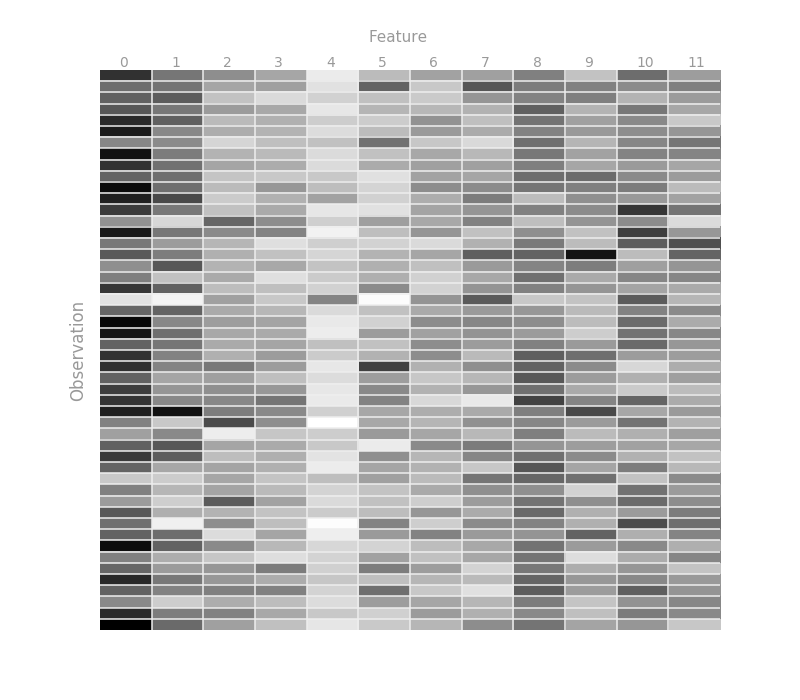

In [125]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# takeSample(withReplacement, num, [seed]) randomly selects num elements from the dataset with/without replacement, and has an
# optional seed parameter that one can set for reproducible results

# data_values = (parsed_points_df
#                .rdd
#                .map(lambda lp: lp.features.toArray())
#                .takeSample(False, 50, 47))

# You can uncomment the line below to see randomly selected features.  These will be randomly
# selected each time you run the cell because there is no set seed.  Note that you should run
# this cell with the line commented out when answering the lab quiz questions.
data_values = (parsed_points_df
               .rdd
               .map(lambda lp: lp.features)
               .takeSample(False, 50))

def prepare_plot(xticks, yticks, figsize=(10.5, 6), hideLabels=False, gridColor='#999999',
                 gridWidth=1.0):
    """Template for generating the plot layout."""
    plt.close()
    fig, ax = plt.subplots(figsize=figsize, facecolor='white', edgecolor='white')
    ax.axes.tick_params(labelcolor='#999999', labelsize='10')
    for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
        axis.set_ticks_position('none')
        axis.set_ticks(ticks)
        axis.label.set_color('#999999')
        if hideLabels: axis.set_ticklabels([])
    plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
    map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])
    return fig, ax

# generate layout and plot
fig, ax = prepare_plot(np.arange(.5, 11, 1), np.arange(.5, 49, 1), figsize=(8,7), hideLabels=True,
                       gridColor='#eeeeee', gridWidth=1.1)
image = plt.imshow(data_values,interpolation='nearest', aspect='auto', cmap=cm.Greys)
for x, y, s in zip(np.arange(-.125, 12, 1), np.repeat(-.75, 12), [str(x) for x in range(12)]):
    plt.text(x, y, s, color='#999999', size='10')
plt.text(4.7, -3, 'Feature', color='#999999', size='11'), ax.set_ylabel('Observation')
display(fig)

### (1c) Find the range

Now let's examine the labels to find the range of song years.  To do this, find the smallest and largest labels in the `parsed_points_df`.

We will use the min and max functions that are native to the DataFrames, and thus can be optimized using Spark's Catalyst Optimizer and Project Tungsten (don't worry about the technical details). This code will run faster than simply using the native min and max functions in Python. Use [selectExpr](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.selectExpr) to retrieve the min and max label values.

In [127]:
# TODO: Replace <FILL IN> with appropriate code
content_stats = (parsed_points_df
                 .selectExpr("min(label)", "max(label)")).collect()

print content_stats

min_year = content_stats[0]["min(label)"]
max_year = content_stats[0]["max(label)"]

# YOUR CODE HERE
# raise NotImplementedError()


print (min_year, max_year)


[Row(min(label)=1922.0, max(label)=2011.0)]
(1922.0, 2011.0)

In [128]:
# TEST Find the range (1c)
assert_equal(len(parsed_points_df.first().features), 12,
                  'unexpected number of features in sample point')
sum_feat_two = parsed_points_df.rdd.map(lambda lp: lp.features[2]).sum()
assert_true(np.allclose(sum_feat_two, 3158.96224351), 'parsedPointsDF has unexpected values')
year_range = max_year - min_year
assert_true(year_range == 89, 'incorrect range for minYear to maxYear')

### (1d) Shift labels

As we just saw, the labels are years in the 1900s and 2000s.  In learning problems, it is often natural to shift labels such that they start from zero.  Starting with `parsed_points_df`, create a new DataFrame in which the labels are shifted such that smallest label equals zero (hint: use `select`). After, use [withColumnRenamed](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.withColumnRenamed) to rename the appropriate columns to `features` and `label`.

In [130]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
parsed_data_df = parsed_points_df.select(parsed_points_df.features, (parsed_points_df.label - min_year)).withColumnRenamed("(label - 1922.0)", "label")

# # View the first point
print ('\n{0}'.format(parsed_data_df.first()))

# YOUR CODE HERE
# raise NotImplementedError()


Row(features=DenseVector([0.8841, 0.6105, 0.6005, 0.4747, 0.2472, 0.3573, 0.3441, 0.3396, 0.6009, 0.4257, 0.6049, 0.4192]), label=79.0)

In [131]:
# TEST Shift labels (1d)
old_sample_features = parsed_points_df.first().features
new_sample_features = parsed_data_df.first().features
assert_true(np.allclose(old_sample_features, new_sample_features),
                'new features do not match old features')
sum_feat_two = parsed_data_df.rdd.map(lambda lp: lp.features[2]).sum()
assert_true(np.allclose(sum_feat_two, 3158.96224351), 'parsed_data_df has unexpected values')
min_year_new = parsed_data_df.groupBy().min('label').first()[0]
max_year_new = parsed_data_df.groupBy().max('label').first()[0]
assert_true(min_year_new == 0, 'incorrect min year in shifted data')
assert_true(max_year_new == 89, 'incorrect max year in shifted data')

### Visualization 2: Shifting labels

We will look at the labels before and after shifting them.  Both scatter plots below visualize tuples storing:

* a label value and
* the number of training points with this label.

The first scatter plot uses the initial labels, while the second one uses the shifted labels.  Note that the two plots look the same except for the labels on the x-axis.

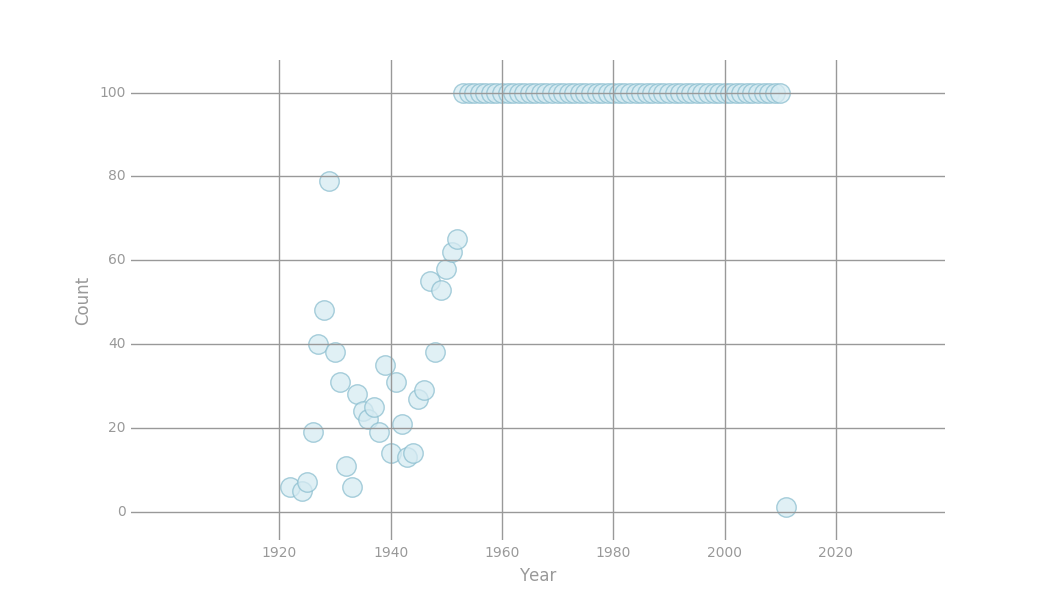

In [133]:
# get data for plot
old_data = (parsed_points_df
             .rdd
             .map(lambda lp: (lp.label, 1))
             .reduceByKey(lambda x, y: x + y)
             .collect())
x, y = zip(*old_data)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(1920, 2050, 20), np.arange(0, 150, 20))
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year'), ax.set_ylabel('Count')
display(fig)

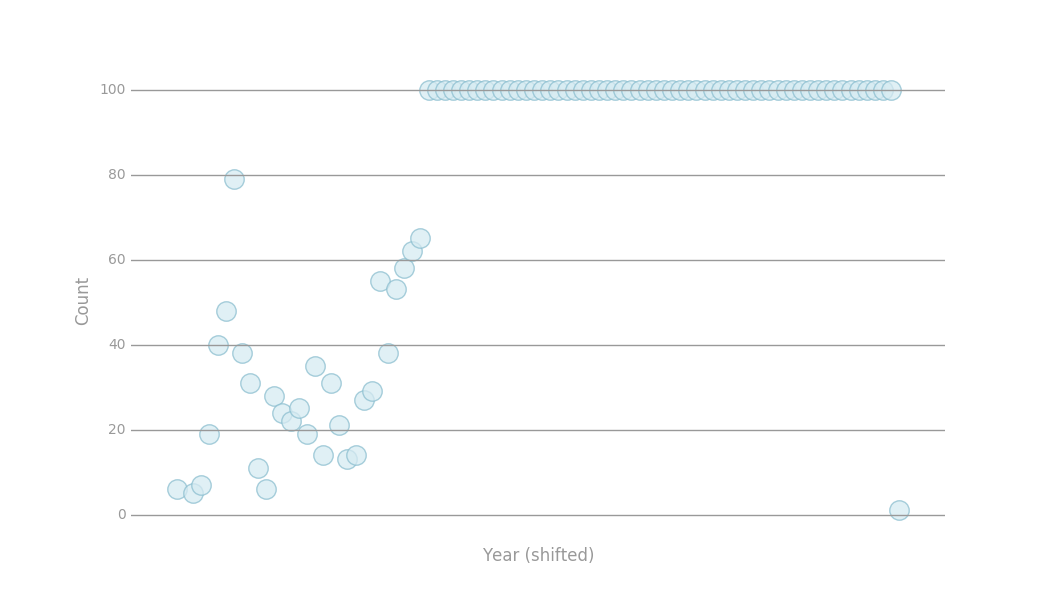

In [134]:
# get data for plot
new_data = (parsed_points_df
             .rdd
             .map(lambda lp: (lp.label, 1))
             .reduceByKey(lambda x, y: x + y)
             .collect())
x, y = zip(*new_data)

# generate layout and plot data
fig, ax = prepare_plot(np.arange(0, 120, 20), np.arange(0, 120, 20))
plt.scatter(x, y, s=14**2, c='#d6ebf2', edgecolors='#8cbfd0', alpha=0.75)
ax.set_xlabel('Year (shifted)'), ax.set_ylabel('Count')
display(fig)
pass

### (1e) Training, validation, and test sets

We're almost done parsing our dataset, and our final task involves spliting the dataset into training, validation and test sets. Use the [randomSplit method](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame.randomSplit) with the specified weights and seed to create DataFrames storing each of these datasets. Next, cache each of these DataFrames, as we will be accessing them multiple times in the remainder of this lab. Finally, compute the size of each dataset and verify that the sum of their sizes equals the value computed in Part (1a).

In [136]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
weights = [.8, .1, .1]
seed = 42
parsed_train_data_df, parsed_val_data_df, parsed_test_data_df = parsed_data_df.randomSplit(weights, seed)
parsed_train_data_df.cache()
parsed_val_data_df.cache()
parsed_test_data_df.cache()
n_train = parsed_train_data_df.count()
n_val = parsed_val_data_df.count()
n_test = parsed_test_data_df.count()


# YOUR CODE HERE
# raise NotImplementedError()

print (n_train, n_val, n_test, n_train + n_val + n_test)
print (parsed_data_df.count())


(5405, 644, 675, 6724)
6724

In [137]:
# TEST Training, validation, and test sets (1e)
assert_equal(len(parsed_train_data_df.first().features), 12,
                  'parsed_train_data_df has wrong number of features')
sum_feat_two = (parsed_train_data_df
                 .rdd
                 .map(lambda lp: lp.features[2])
                 .sum())
sum_feat_three = (parsed_val_data_df
                  .rdd
                  .map(lambda lp: lp.features[3])
                  .reduce(lambda x, y: x + y))
sum_feat_four = (parsed_test_data_df
                  .rdd
                  .map(lambda lp: lp.features[4])
                  .reduce(lambda x, y: x + y))
assert_true(np.allclose([sum_feat_two, sum_feat_three, sum_feat_four],
                            2526.87757656, 297.340394298, 184.235876654),
                'parsed Train, Val, Test data has unexpected values')
assert_true(n_train + n_val + n_test == 6724, 'unexpected Train, Val, Test data set size')
assert_equal(n_train, 5405, 'unexpected value for nTrain')
assert_equal(n_val, 644, 'unexpected value for nVal')
assert_equal(n_test, 675, 'unexpected value for nTest')

## Part 2: Create and evaluate a baseline model

### (2a) Average label

A very simple yet natural baseline model is one where we always make the same prediction independent of the given data point, using the average label in the training set as the constant prediction value.  Compute this value, which is the average (shifted) song year for the training set.  Use `selectExpr` and `first()` from the [DataFrame API](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.DataFrame).

In [140]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
average_train_year = (parsed_train_data_df
                        .selectExpr("Avg(label)").withColumnRenamed("avg(label)", "label").first()["label"])
# average_train_year = (parsed_train_data_df.groupBy().avg("label").first()["avg(label)"])
print average_train_year

# YOUR CODE HERE
# raise NotImplementedError()

print (average_train_year)

53.6814061055
53.6814061055

In [141]:
# TEST Average label (2a)
assert_true(np.allclose(average_train_year, 53.68140610545791),
                'incorrect value for average_train_year')

### (2b) Root mean squared error

We naturally would like to see how well this naive baseline performs.  We will use root mean squared error ([RMSE](http://en.wikipedia.org/wiki/Root-mean-square_deviation)) for evaluation purposes.  Using [Regression Evaluator](http://spark.apache.org/docs/latest/api/python/pyspark.ml.html#pyspark.ml.evaluation.RegressionEvaluator),  compute the RMSE given a dataset of _(prediction, label)_ tuples.

In [143]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
from pyspark.ml.evaluation import RegressionEvaluator
import math

preds_and_labels = [(1., 3.), (2., 1.), (2., 2.)]
preds_and_labels_df = sqlContext.createDataFrame(preds_and_labels, ["prediction", "label"])


evaluator = RegressionEvaluator()
# print evaluator.evaluate(preds_and_labels_df, {evaluator.metricName: "rmse"})
# YOUR CODE HERE
# raise NotImplementedError()
def calc_sqE(predict, actual):
  """Calculates the square error between prediction and actual value.
    
    Args:
      predict (float): predicted label
      actual (float): actual label
      
    Returns:
      float: The square error between predict and actual
  """
  return (predice - actual) ** 2

def calc_RMSE(dataset):
    """Calculates the root mean squared error for an dataset of (prediction, label) tuples.

    Args:
        dataset (DataFrame of (float, float)): A `DataFrame` consisting of (prediction, label) tuples.

    Returns:
        float: The square root of the mean of the squared errors.
    """
    # return evaluator.<FILL IN>
    # YOUR CODE HERE
    return evaluator.evaluate(dataset, {evaluator.metricName: "rmse"})
    
    
    
#     raise NotImplementedError()

example_rmse = calc_RMSE(preds_and_labels_df)
print (example_rmse)
# RMSE = math.sqrt[((1-3)^2 + (2-1)^2 + (2-2)^2) / 3] = 1.291


1.29099444874

In [144]:
# TEST Root mean squared error (2b)
assert_true(np.allclose(example_rmse, 1.29099444874), 'incorrect value for exampleRMSE')

### (2c) Training, validation and test RMSE

Now let's calculate the training, validation and test RMSE of our baseline model. To do this, first create DataFrames of _(prediction, label)_ tuples for each dataset, and then call `calc_RMSE()`. Note that each RMSE can be interpreted as the average prediction error for the given dataset (in terms of number of years). You can use [createDataFrame](https://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.SQLContext.createDataFrame) to make a DataFrame with the column names of "prediction" and "label" from an RDD.

In [146]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
preds_and_labels_train = parsed_train_data_df.rdd.map(lambda line: (average_train_year, line["label"]))
print preds_and_labels_train.take(5)
preds_and_labels_train_df = sqlContext.createDataFrame(preds_and_labels_train, ["prediction", "label"])
rmse_train_base = calc_RMSE(preds_and_labels_train_df)

preds_and_labels_val = parsed_val_data_df.rdd.map(lambda line: (average_train_year, line["label"]))
preds_and_labels_val_df = sqlContext.createDataFrame(preds_and_labels_val, ["prediction", "label"])
rmse_val_base = calc_RMSE(preds_and_labels_val_df)

preds_and_labels_test = parsed_test_data_df.rdd.map(lambda line: (average_train_year, line["label"]))
preds_and_labels_test_df = sqlContext.createDataFrame(preds_and_labels_test, ["prediction", "label"])
rmse_test_base = calc_RMSE(preds_and_labels_test_df)



# YOUR CODE HERE
# raise NotImplementedError()

print ('Baseline Train RMSE = {0:.3f}'.format(rmse_train_base))
print ('Baseline Validation RMSE = {0:.3f}'.format(rmse_val_base))
print ('Baseline Test RMSE = {0:.3f}'.format(rmse_test_base))


[(53.68140610545791, 59.0), (53.68140610545791, 35.0), (53.68140610545791, 62.0), (53.68140610545791, 6.0), (53.68140610545791, 35.0)]
Baseline Train RMSE = 21.477
Baseline Validation RMSE = 21.227
Baseline Test RMSE = 21.127

In [147]:
# TEST Training, validation and test RMSE (2c)
assert_true(np.allclose([rmse_train_base, rmse_val_base, rmse_test_base],
                            [21.477279181895707, 21.22695358728026, 21.127323734084705]), 'incorrect RMSE values')

### Visualization 3: Predicted vs. actual

We will visualize predictions on the validation dataset. The scatter plots below visualize tuples storing i) the predicted value and ii) true label.  The first scatter plot represents the ideal situation where the predicted value exactly equals the true label, while the second plot uses the baseline predictor (i.e., `average_train_year`) for all predicted values.  Further note that the points in the scatter plots are color-coded, ranging from light yellow when the true and predicted values are equal to bright red when they drastically differ.

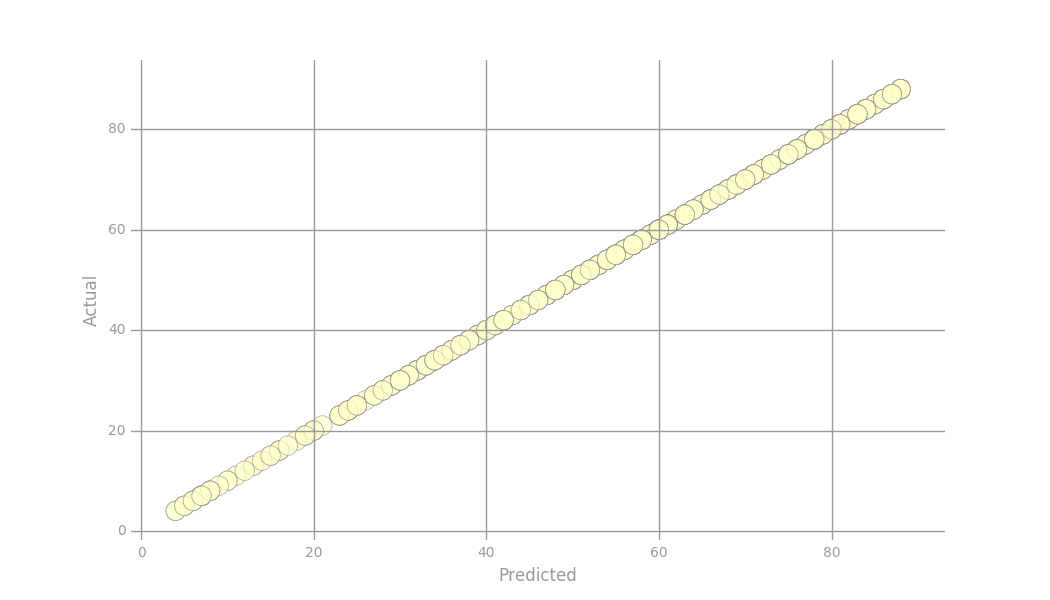

In [149]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import get_cmap
cmap = get_cmap('YlOrRd')
norm = Normalize()

def squared_error(lp):
    """Calculates the squared error for a single prediction."""
    label, prediction = lp
    return float((label - prediction)**2)

actual = np.asarray(parsed_val_data_df
                    .select('label')
                    .collect())
error = np.asarray(parsed_val_data_df
                   .rdd
                   .map(lambda lp: (lp.label, lp.label))
                   .map(lambda lp: squared_error(lp))
                   .collect())
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 100, 20), np.arange(0, 100, 20))
plt.scatter(actual, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.5)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
display(fig)

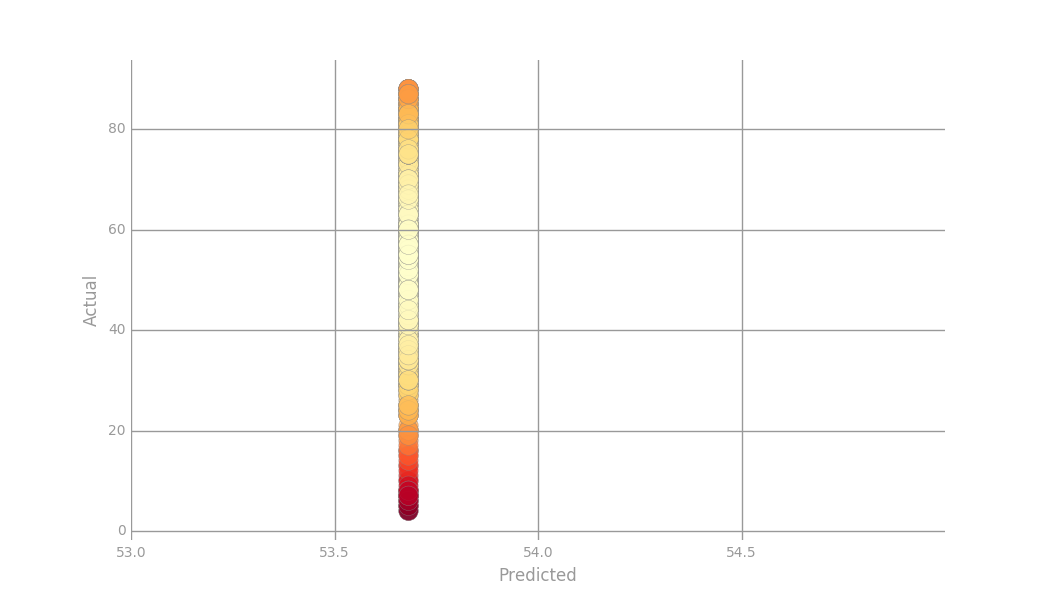

In [150]:
def squared_error(lp):
    """Calculates the squared error for a single prediction."""
    label, prediction = lp
    return float((label - prediction)**2)

predictions = np.asarray(parsed_val_data_df
                         .rdd
                         .map(lambda lp: average_train_year)
                         .collect())
error = np.asarray(parsed_val_data_df
                   .rdd
                   .map(lambda lp: (lp.label, average_train_year))
                   .map(lambda lp: squared_error(lp))
                   .collect())
norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepare_plot(np.arange(53.0, 55.0, 0.5), np.arange(0, 100, 20))
ax.set_xlim(53, 55)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=0.3)
ax.set_xlabel('Predicted'), ax.set_ylabel('Actual')
display(fig)

## Part 3: Train (via gradient descent) and evaluate a linear regression model

### (3a) Gradient summand

Now let's see if we can do better via linear regression, training a model via gradient descent (we'll omit the intercept for now). Recall that the gradient descent update for linear regression is:
\\[ \scriptsize \mathbf{w}_{i+1} = \mathbf{w}_i - \alpha_i \sum_j (\mathbf{w}_i^\top\mathbf{x}_j  - y_j) \mathbf{x}_j \,.\\]
where \\( \scriptsize i \\) is the iteration number of the gradient descent algorithm, and \\( \scriptsize j \\) identifies the observation.

First, implement a function that computes the summand for this update, i.e., the summand equals \\( \scriptsize (\mathbf{w}^\top \mathbf{x} - y) \mathbf{x} \, ,\\) and test out this function on two examples.  Use the `DenseVector` [dot](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.linalg.DenseVector.dot) method.

In [153]:
from pyspark.mllib.linalg import DenseVector

In [154]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
def gradient_summand(weights, lp):
    """Calculates the gradient summand for a given weight and `LabeledPoint`.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        weights (DenseVector): An array of model weights (betas).
        lp (LabeledPoint): The `LabeledPoint` for a single observation.

    Returns:
        DenseVector: An array of values the same length as `weights`.  The gradient summand.
    """
    # return <FILL IN>
    # YOUR CODE HERE
    return (weights.T.dot(lp.features) - lp.label) * lp.features
#     raise NotImplementedError()

example_w = DenseVector([1, 1, 1])
example_lp = LabeledPoint(2.0, [3, 1, 4])
# gradient_summand = (dot([1 1 1], [3 1 4]) - 2) * [3 1 4] = (8 - 2) * [3 1 4] = [18 6 24]
summand_one = gradient_summand(example_w, example_lp)
print (summand_one)

example_w = DenseVector([.24, 1.2, -1.4])
example_lp = LabeledPoint(3.0, [-1.4, 4.2, 2.1])
summand_two = gradient_summand(example_w, example_lp)
print (summand_two)


[18.0,6.0,24.0]
[1.7304,-5.1912,-2.5956]

In [155]:
# TEST Gradient summand (3a)
assert_true(np.allclose(summand_one, [18., 6., 24.]), 'incorrect value for summand_one')

### (3b) Use weights to make predictions

Next, implement a `get_labeled_predictions` function that takes in weights and an observation's `LabeledPoint` and returns a _(prediction, label)_ tuple.  Note that we can predict by computing the dot product between weights and an observation's features.

In [157]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
def get_labeled_prediction(weights, observation):
    """Calculates predictions and returns a (prediction, label) tuple.

    Note:
        The labels should remain unchanged as we'll use this information to calculate prediction
        error later.

    Args:
        weights (np.ndarray): An array with one weight for each features in `trainData`.
        observation (LabeledPoint): A `LabeledPoint` that contain the correct label and the
            features for the data point.

    Returns:
        tuple: A (prediction, label) tuple. Convert the return type of the label and prediction to a float.
    """
    # return <FILL IN>
    # YOUR CODE HERE
    return (observation.features.dot(weights), observation.label)
#     raise NotImplementedError()
  

weights = np.array([1.0, 1.5])
prediction_example = sc.parallelize([LabeledPoint(2, np.array([1.0, .5])),
                                     LabeledPoint(1.5, np.array([.5, .5]))])
preds_and_labels_example = prediction_example.map(lambda lp: get_labeled_prediction(weights, lp))
print (preds_and_labels_example.collect())





[(1.75, 2.0), (1.25, 1.5)]

In [158]:
# TEST Use weights to make predictions (3b)
assert_true(isinstance(preds_and_labels_example.first()[0], float), 'prediction must be a float')
assert_equal(preds_and_labels_example.collect(), [(1.75, 2.0), (1.25, 1.5)],
                  'incorrect definition for getLabeledPredictions')

### (3c) Gradient descent

Next, implement a gradient descent function for linear regression and test out this function on an example.

In [160]:
# TODO: Uncomment the follosing lines and replace <FILL IN> with appropriate code
def linreg_gradient_descent(train_data, num_iters):
    """Calculates the weights and error for a linear regression model trained with gradient descent.

    Note:
        `DenseVector` behaves similarly to a `numpy.ndarray` and they can be used interchangably
        within this function.  For example, they both implement the `dot` method.

    Args:
        train_data (RDD of LabeledPoint): The labeled data for use in training the model.
        num_iters (int): The number of iterations of gradient descent to perform.

    Returns:
        (np.ndarray, np.ndarray): A tuple of (weights, training errors).  Weights will be the
            final weights (one weight per feature) for the model, and training errors will contain
            an error (RMSE) for each iteration of the algorithm.
    """
    # The length of the training data
    n = train_data.count()
    # The number of features in the training data
    d = len(train_data.first().features)
    w = np.zeros(d)
    alpha = 1.0
    # We will compute and store the training error after each iteration
    error_train = np.zeros(num_iters)
    for i in range(num_iters):
#         # Use get_labeled_prediction from (3b) with trainData to obtain an RDD of (label, prediction)
#         # tuples.  Note that the weights all equal 0 for the first iteration, so the predictions will
#         # have large errors to start.
        preds_and_labels_train = train_data.map(lambda lp: get_labeled_prediction(w, lp)).map(lambda line: (float(line[0]), float(line[1])))
        preds_and_labels_train_df = sqlContext.createDataFrame(preds_and_labels_train, ["prediction", "label"])
        error_train[i] = calc_RMSE(preds_and_labels_train_df)

#         # Calculate the `gradient`.  Make use of the `gradient_summand` function you wrote in (3a).
#         # Note that `gradient` should be a `DenseVector` of length `d`.
        gradient = train_data.map(lambda line: gradient_summand(w, line)).sum()

        # Update the weights
        alpha_i = alpha / (n * np.sqrt(i+1))
        w -= alpha_i * gradient
    return w, error_train
  
    # YOUR CODE HERE
#     raise NotImplementedError()

# create a toy dataset with n = 10, d = 3, and then run 5 iterations of gradient descent
# note: the resulting model will not be useful; the goal here is to verify that
# linreg_gradient_descent is working properly
example_n = 10
example_d = 3
example_data = (sc
                 .parallelize(parsed_train_data_df.take(example_n))
                 .map(lambda lp: LabeledPoint(lp.label, lp.features[0:example_d])))
print (example_data.take(2))
example_num_iters = 5
example_weights, example_error_train = linreg_gradient_descent(example_data, example_num_iters)
print (example_weights)


[LabeledPoint(59.0, [0.0,0.696269780071,0.395207288435]), LabeledPoint(35.0, [0.0305925311676,0.402530811194,0.296196625953])]
[ 3.6706757 28.77277769 17.91957382]

In [161]:
# TEST Gradient descent (3c)

expected_output = [ 3.6706757 , 28.77277769, 17.91957382]
assert_true(np.allclose(example_weights, expected_output), 'value of example_weights is incorrect')
expected_error = [38.71433843 ,32.45595388, 30.22343598, 29.10818648, 28.46448674]
assert_true(np.allclose(example_error_train, expected_error),
                'value of exampleErrorTrain is incorrect')

### (3d) Train the model

Now let's train a linear regression model on all of our training data and evaluate its accuracy on the validation set.  Note that the test set will not be used here.  If we evaluated the model on the test set, we would bias our final results.

We've already done much of the required work: we computed the number of features in Part (1b); we created the training and validation datasets and computed their sizes in Part (1e); and, we wrote a function to compute RMSE in Part (2b).

In [163]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
num_iters = 50
weights_LR0, error_train_LR0 = linreg_gradient_descent(parsed_train_data_df.rdd, num_iters)

preds_and_labels = (parsed_val_data_df
                      .rdd.map(lambda lp: get_labeled_prediction(weights_LR0, lp))).map(lambda line: (float(line[0]), float(line[1])))
preds_and_labels_df = sqlContext.createDataFrame(preds_and_labels, ["prediction", "label"])
rmse_val_LR0 = calc_RMSE(preds_and_labels_df)

print ('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}'.format(rmse_val_base,
                                                                       rmse_val_LR0))

# YOUR CODE HERE
# raise NotImplementedError()

print weights_LR0

Validation RMSE:
	Baseline = 21.227
	LR0 = 18.776
[ 22.49753756 20.37597243 -0.27251763 8.31521579 5.88853769
 -4.82949119 15.60187764 3.97275651 9.93959836 6.06173598
 10.9900427 3.72333163]

In [164]:
# TEST Train the model (3d)
expected_output =[22.49753756, 20.37597243, -0.27251763,  8.31521579,  5.88853769, -4.82949119,
                   15.60187764,  3.97275651,  9.93959836,  6.06173598, 10.9900427,   3.72333163]
assert_true(np.allclose(weights_LR0, expected_output), 'incorrect value for weights_LR0')

### Visualization 4: Training error

We will look at the log of the training error as a function of iteration. The first scatter plot visualizes the logarithm of the training error for all 50 iterations.  The second plot shows the training error itself, focusing on the final 44 iterations.

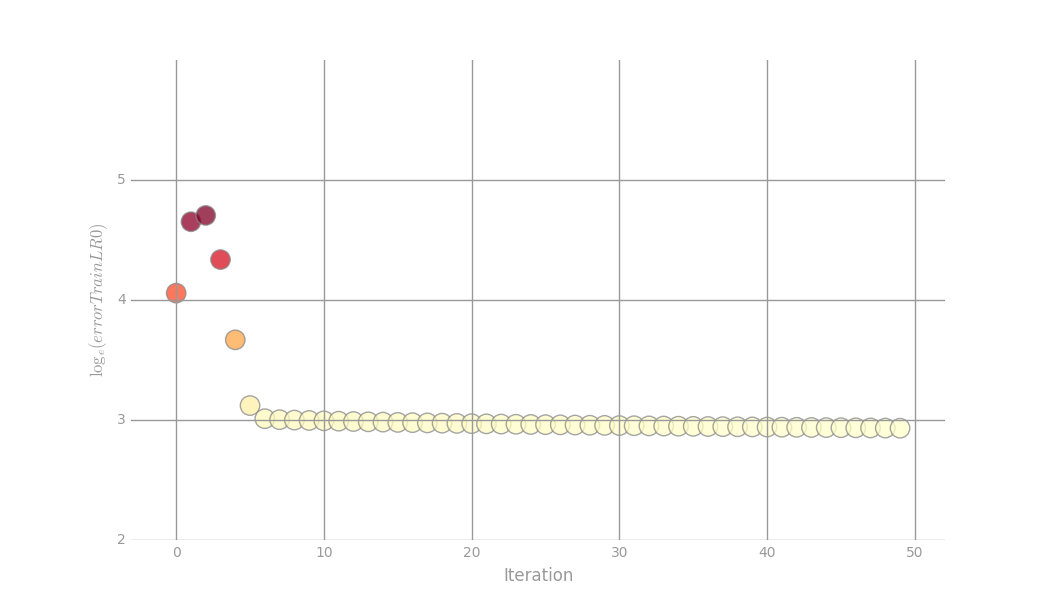

In [166]:
norm = Normalize()
clrs = cmap(np.asarray(norm(np.log(error_train_LR0))))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 60, 10), np.arange(2, 6, 1))
ax.set_ylim(2, 6)
plt.scatter(range(0, num_iters), np.log(error_train_LR0), s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xlabel('Iteration'), ax.set_ylabel(r'$\log_e(errorTrainLR0)$')
display(fig)

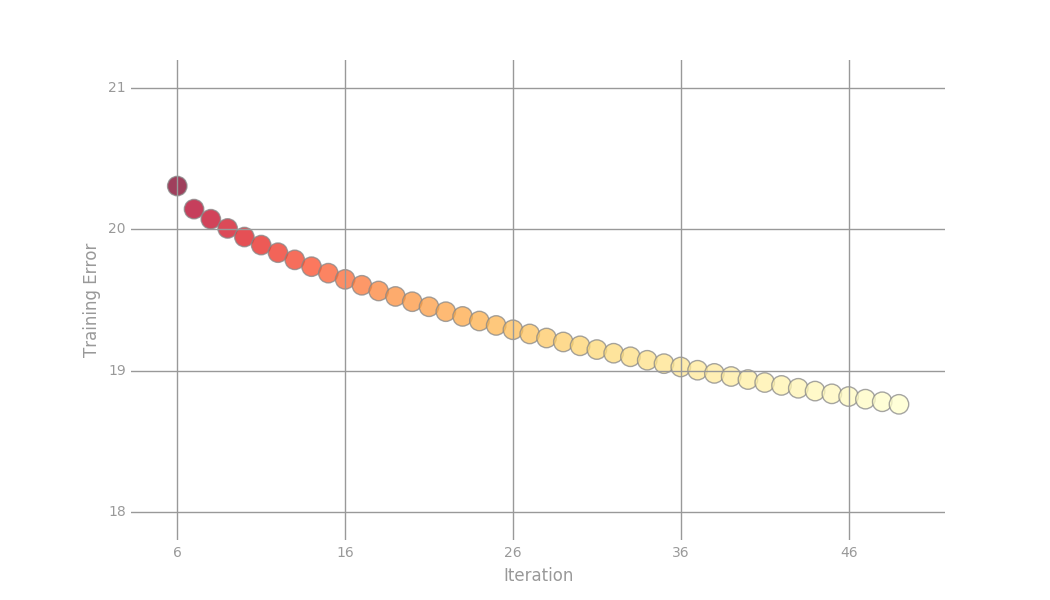

In [167]:
norm = Normalize()
clrs = cmap(np.asarray(norm(error_train_LR0[6:])))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 60, 10), np.arange(17, 22, 1))
ax.set_ylim(17.8, 21.2)
plt.scatter(range(0, num_iters-6), error_train_LR0[6:], s=14**2, c=clrs, edgecolors='#888888', alpha=0.75)
ax.set_xticklabels(map(str, range(6, 66, 10)))
ax.set_xlabel('Iteration'), ax.set_ylabel(r'Training Error')
display(fig)

## Part 4: Train using SparkML and perform grid search

### (4a) `LinearRegression`
We're already doing better than the baseline model, but let's see if we can do better by adding an intercept, using regularization, and (based on the previous visualization) training for more iterations. MLlib's [LinearRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionWithSGD) essentially applys smae idea that we used in Part (3b), albeit using stochastic gradient approximation and more efficiently with various additional functionality including an intercept in the model and also allowing L1 or L2 regularization.

First use [LinearRegressionWithSGD](https://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionWithSGD) to train a model with L2 regularization and with an intercept. This method returns a LinearRegressionModel. Next, use the model's weights (ex model.weights) and intercept (ex model.intercept) attributes to print out the model's parameters

In [170]:
from pyspark.mllib.regression import LinearRegressionWithSGD
# Values to use when training the linear regression model
numIters = 500  # iterations
alpha = 1.0  # step
miniBatchFrac = 1.0  # miniBatchFraction
reg = 1e-1  # regParam
regType = 'l2'  # regType
useIntercept = True  # intercept

In [171]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code

# # The data parameter takes in the training data that is an RDD of LabeledPoint. 
# # You may want to transform parsed_train_data_df to required type via map.
first_model = LinearRegressionWithSGD.train(data=parsed_train_data_df.rdd.map(lambda line: LabeledPoint(line[1], line[0])), 
                                           iterations=numIters, 
                                           step=alpha, 
                                           miniBatchFraction=miniBatchFrac, 
                                           initialWeights=None, 
                                           regParam=reg, 
                                           regType=regType, 
                                           intercept=useIntercept
                                           )

# # coeffsLR1 stores the model coefficients; interceptLR1 stores the model intercept
coeffs_LR1 = first_model.weights
intercept_LR1 = first_model.intercept
print (coeffs_LR1, intercept_LR1)


# YOUR CODE HERE
# raise NotImplementedError()
# print parsed_train_data_df.rdd.map(lambda line: LabeledPoint(line[1], line[0])).take(4)

(DenseVector([15.9081, 14.1417, 0.6362, 6.1325, 3.9744, -2.5115, 10.5512, 3.1087, 7.2478, 4.7031, 7.7605, 3.0766]), 13.272917647663501)

In [172]:
# TEST LinearRegression (4a)
expected_intercept = 13.272917647663501
expected_weights= [15.90811601077196,14.141747071778694,0.6361803544493579,6.1325094710269825,3.974387960587376,-2.5115097734889575,10.55122835853148,3.108716057088987,7.247819807528351,4.703102469082578,7.760457489026197,3.0765704673716043]

assert_true(np.allclose(intercept_LR1, expected_intercept), 'incorrect value for intercept_LR1')
assert_true(np.allclose(coeffs_LR1, expected_weights), 'incorrect value for weights_LR1')

### (4b) Predict

Now use the [LinearRegressionModel.predict()](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.predict) method to make a prediction on a sample point. Pass the features from a LabeledPoint into the predict() method

In [174]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
samplePoint = parsed_train_data_df.take(1)[0]
# print samplePoint[0], samplePoint[0][1]
sample_prediction = first_model.predict(samplePoint[0])
print (sample_prediction)

# YOUR CODE HERE
# raise NotImplementedError()


[0.0,0.696269780071,0.395207288435,0.360177132981,0.376385935537,0.504357247962,0.37524825154,0.661319989571,0.36998946078,0.61102796964,0.177714974246,0.345702163596] 0.696269780071
39.8220638649

In [175]:
# TEST Predict (4b)
assert_true(np.allclose(sample_prediction, 39.82206386491484),
                'incorrect value for sample_prediction')

### (4c) Evaluate RMSE

Next evaluate the accuracy of this model on the validation set.  First, map [LinearRegressionModel.predict()](http://spark.apache.org/docs/latest/api/python/pyspark.mllib.html#pyspark.mllib.regression.LinearRegressionModel.predict) method on features in parsed_val_data_df to get labelsAndPreds. Create a dataframe based on that and then use the `calc_RMSE()` function from Part (2b).

In [177]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
labels_and_preds = parsed_val_data_df.rdd.map(lambda lp: (lp.label, float(first_model.predict(lp.features)))).collect()
    
labels_and_preds_df = sqlContext.createDataFrame(labels_and_preds, ["label", "prediction"])

print labels_and_preds_df.head(5)
rmse_val_LR1 = calc_RMSE(labels_and_preds_df)

# YOUR CODE HERE
# raise NotImplementedError()

print(rmse_val_LR1)



[Row(label=5.0, prediction=41.16202111135229), Row(label=62.0, prediction=36.7105389528268), Row(label=6.0, prediction=41.90993034185346), Row(label=35.0, prediction=41.4167596275379), Row(label=60.0, prediction=42.310797857477255)]
19.4945226475

In [178]:
# TEST Evaluate RMSE (4c)
assert_true(np.allclose(rmse_val_LR1, 19.49452264747249), 'incorrect value for rmseValLR1')

### (4d) Grid search

We're already outperforming the baseline on the validation set by almost 2 years on average, but let's see if we can do better. Perform grid search to find a good regularization parameter.  Try `regParam` values `1e-10`, `1e-5`, and `1.0`.

In [180]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
best_RMSE = rmse_val_LR1
best_reg_param = reg
best_model = first_model

num_iters = 500  # iterations
alpha = 1.0 # step
miniBatchFrac = 1.0

for reg in [1e-10, 1e-5, 1.0]:
    model = LinearRegressionWithSGD.train(data = parsed_train_data_df.rdd.map(lambda line: LabeledPoint(line[1], line[0])),
                                          iterations=numIters, 
                                           step=alpha, 
                                           miniBatchFraction=miniBatchFrac, 
                                           initialWeights=None, 
                                           regParam=reg, 
                                           regType=regType, 
                                           intercept=useIntercept
                                         )

    labels_and_preds = parsed_val_data_df.rdd.map(lambda lp: (lp.label, float(model.predict(lp.features)))).collect()
    
    labels_and_preds_df = sqlContext.createDataFrame(labels_and_preds, ["label", "prediction"])
    rmse_val_grid = calc_RMSE(labels_and_preds_df)
    print (rmse_val_grid)

    if rmse_val_grid < best_RMSE:
        best_RMSE = rmse_val_grid
        best_reg_param = reg
        best_model = model

rmse_val_LR_grid = best_RMSE

print (('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n' +
       '\tLRGrid = {3:.3f}').format(rmse_val_base, rmse_val_LR0, rmse_val_LR1, rmse_val_LR_grid))

# YOUR CODE HERE
# raise NotImplementedError()


17.1916540261
17.1919597117
23.6476196265
Validation RMSE:
	Baseline = 21.227
	LR0 = 18.776
	LR1 = 19.495
	LRGrid = 17.192

In [181]:
# TEST Grid search (4d)
assert_true(np.allclose(17.19165402610348, rmse_val_LR_grid), 'incorrect value for rmseValLRGrid')

### Visualization 5: Best model's predictions

Next, we create a visualization similar to 'Visualization 3: Predicted vs. actual' from Part 2 using the predictions from the best model from Part (4d) on the validation dataset.  Specifically, we create a color-coded scatter plot visualizing tuples storing i) the predicted value from this model and ii) true label.

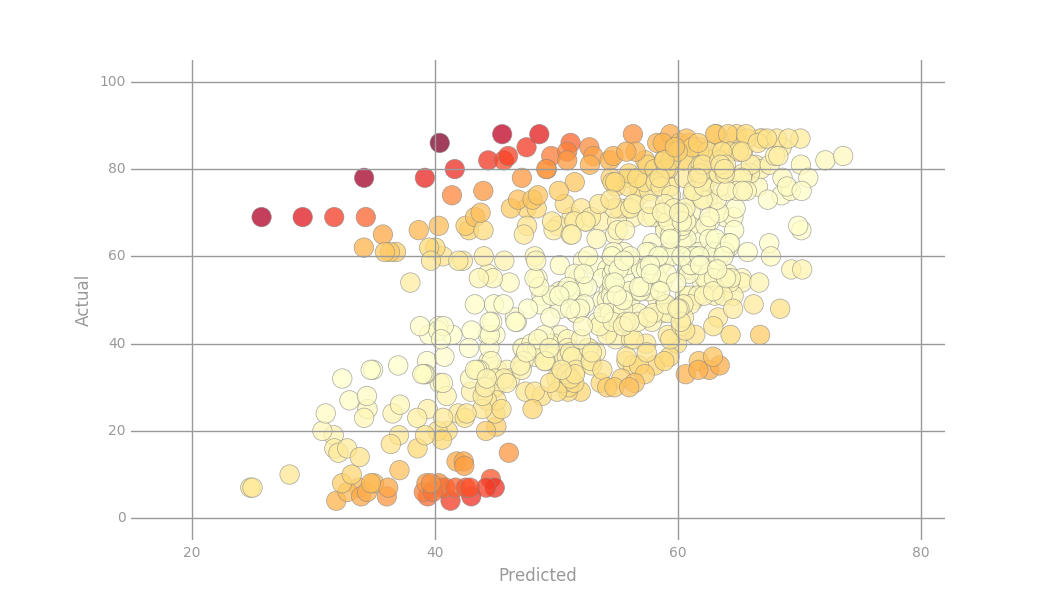

In [183]:
predictions = np.asarray(parsed_val_data_df.rdd
                         .map(lambda lp: best_model.predict(lp.features))
                         .collect())
actual = np.asarray(parsed_val_data_df.rdd
                    .map(lambda lp: lp.label)
                    .collect())
error = np.asarray(parsed_val_data_df.rdd
                   .map(lambda lp: (lp.label, best_model.predict(lp.features)))
                   .map( lambda lp: squared_error(lp))
                   .collect())

norm = Normalize()
clrs = cmap(np.asarray(norm(error)))[:,0:3]

fig, ax = prepare_plot(np.arange(0, 120, 20), np.arange(0, 120, 20))
ax.set_xlim(15, 82), ax.set_ylim(-5, 105)
plt.scatter(predictions, actual, s=14**2, c=clrs, edgecolors='#888888', alpha=0.75, linewidths=.5)
ax.set_xlabel('Predicted'), ax.set_ylabel(r'Actual')
display(fig) 
pass



### Visualization 6: Hyperparameter heat map

Next, we perform a visualization of hyperparameter search using a larger set of hyperparameters (with precomputed results).  Specifically, we create a heat map where the brighter colors correspond to lower RMSE values.  The first plot has a large area with brighter colors.  In order to differentiate within the bright region, we generate a second plot corresponding to the hyperparameters found within that region.

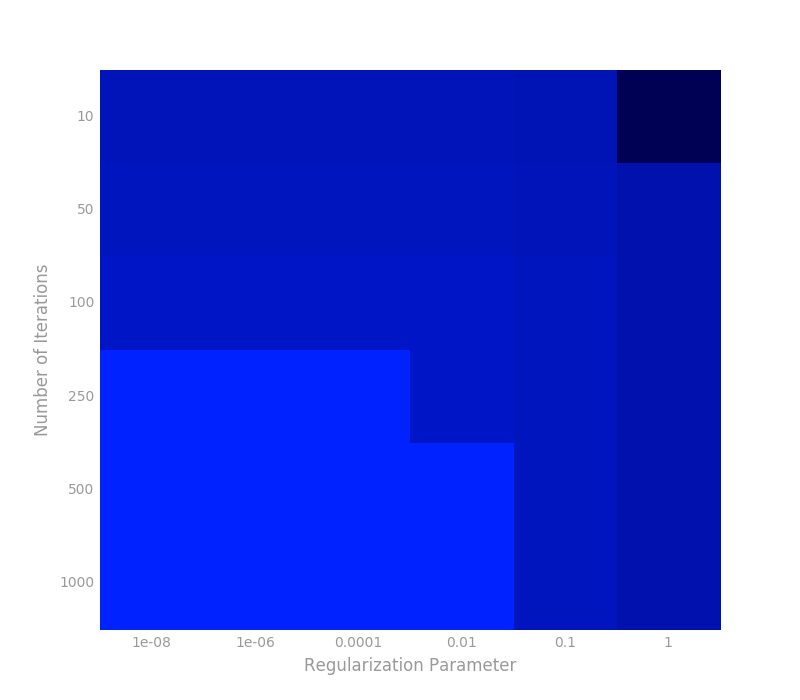

In [185]:
from matplotlib.colors import LinearSegmentedColormap

# Saved parameters and results, to save the time required to run 36 models
numItersParams = [10, 50, 100, 250, 500, 1000]
regParams = [1e-8, 1e-6, 1e-4, 1e-2, 1e-1, 1]
rmseVal = np.array([[  20.36769649,   20.36770128,   20.36818057,   20.41795354,  21.09778437,  301.54258421],
                    [  19.04948826,   19.0495    ,   19.05067418,   19.16517726,  19.97967727,   23.80077467],
                    [  18.40149024,   18.40150998,   18.40348326,   18.59457491,  19.82155716,   23.80077467],
                    [  17.5609346 ,   17.56096749,   17.56425511,   17.88442127,  19.71577117,   23.80077467],
                    [  17.0171705 ,   17.01721288,   17.02145207,   17.44510574,  19.69124734,   23.80077467],
                    [  16.58074813,   16.58079874,   16.58586512,   17.11466904,  19.6860931 ,   23.80077467]])

numRows, numCols = len(numItersParams), len(regParams)
rmseVal = np.array(rmseVal)
rmseVal.shape = (numRows, numCols)

fig, ax = prepare_plot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7), hideLabels=True,
                      gridWidth=0.)
ax.set_xticklabels(regParams), ax.set_yticklabels(numItersParams)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Number of Iterations')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmseVal,interpolation='nearest', aspect='auto',
                    cmap = colors)
display(fig) 

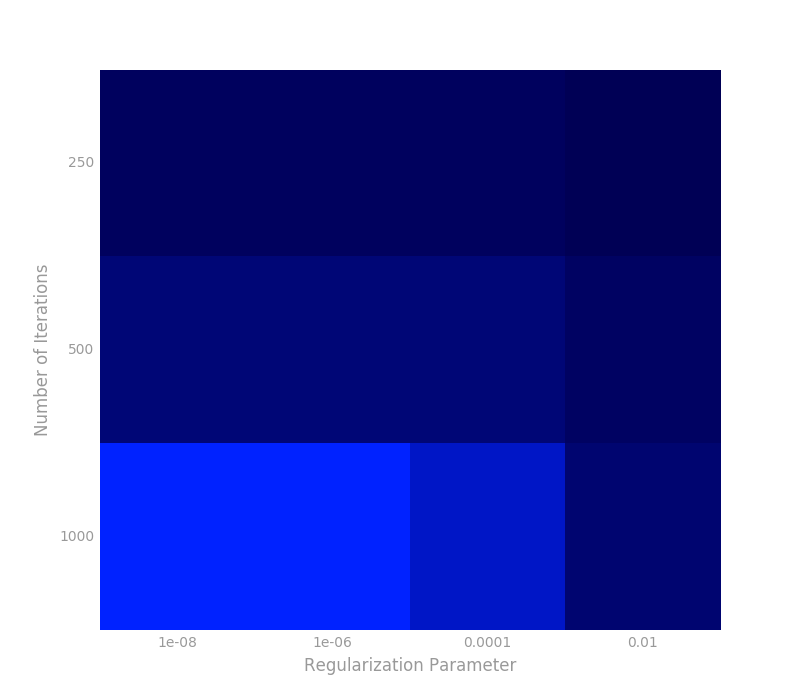

In [186]:
# Zoom into the bottom left
numItersParamsZoom, regParamsZoom = numItersParams[-3:], regParams[:4]
rmseValZoom = rmseVal[-3:, :4]

numRows, numCols = len(numItersParamsZoom), len(regParamsZoom)

fig, ax = prepare_plot(np.arange(0, numCols, 1), np.arange(0, numRows, 1), figsize=(8, 7), hideLabels=True,
                      gridWidth=0.)
ax.set_xticklabels(regParamsZoom), ax.set_yticklabels(numItersParamsZoom)
ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Number of Iterations')

colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
image = plt.imshow(rmseValZoom,interpolation='nearest', aspect='auto',
                    cmap = colors)
display(fig) 
pass

## Part 5: Add interactions between features

### (5a) Add 2-way interactions

So far, we've used the features as they were provided.  Now, we will add features that capture the two-way interactions between our existing features.  Write a function `two_way_interactions` that takes in a `LabeledPoint` and generates a new `LabeledPoint` that contains the old features and the two-way interactions between them.

> Note:
> * A dataset with three features would have nine ( \\( \scriptsize 3^2 \\) ) two-way interactions.
> * You might want to use [itertools.product](https://docs.python.org/2/library/itertools.html#itertools.product) to generate tuples for each of the possible 2-way interactions.
> * Remember that you can combine two `DenseVector` or `ndarray` objects using [np.hstack](http://docs.scipy.org/doc/numpy/reference/generated/numpy.hstack.html#numpy.hstack).

In [189]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
import itertools

def two_way_interactions(lp):
    """Creates a new `LabeledPoint` that includes two-way interactions.

    Note:
        For features [x, y] the two-way interactions would be [x^2, x*y, y*x, y^2] and these
        would be appended to the original [x, y] feature list.

    Args:
        lp (LabeledPoint): The label and features for this observation.

    Returns:
        LabeledPoint: The new `LabeledPoint` should have the same label as `lp`.  Its features
            should include the features from `lp` followed by the two-way interaction features.
    """
    newFeatures = [item[0] * item[1] for item in itertools.product(lp.features, lp.features)]
    return LabeledPoint(lp.label, np.hstack((lp.features, newFeatures)))
    # YOUR CODE HERE
#     raise NotImplementedError()

print (two_way_interactions(LabeledPoint(0.0, [2, 3])))

# # Transform the existing train, validation, and test sets to include two-way interactions.
# # Remember to convert them back to DataFrames at the end.
train_data_interact_df = sqlContext.createDataFrame(parsed_train_data_df.rdd.map(lambda line: two_way_interactions(LabeledPoint(line[1], line[0]))).collect())
val_data_interact_df = sqlContext.createDataFrame(parsed_val_data_df.rdd.map(lambda line: two_way_interactions(LabeledPoint(line[1], line[0]))).collect())
test_data_interact_df = sqlContext.createDataFrame(parsed_test_data_df.rdd.map(lambda line: two_way_interactions(LabeledPoint(line[1], line[0]))).collect())
print len(train_data_interact_df.first()["features"])
print len(val_data_interact_df.first()["features"])

# YOUR CODE HERE
# raise NotImplementedError()


(0.0,[2.0,3.0,4.0,6.0,6.0,9.0])
156
156

In [190]:
# TEST Add two-way interactions (5a)
two_way_example = two_way_interactions(LabeledPoint(0.0, [2, 3]))

assert_true(np.allclose(sorted(two_way_example.features),
                            sorted([2.0, 3.0, 4.0, 6.0, 6.0, 9.0])),
                'incorrect features generatedBy two_way_interactions')

two_way_point = two_way_interactions(LabeledPoint(1.0, [1, 2, 3]))

assert_true(np.allclose(sorted(two_way_point.features),
                            sorted([1.0,2.0,3.0,1.0,2.0,3.0,2.0,4.0,6.0,3.0,6.0,9.0])),
                'incorrect features generated by twoWayInteractions')


assert_equal(two_way_point.label, 1.0, 'incorrect label generated by two_way_interactions')


### (5b) Build interaction model

Now, let's build the new model.  We've done this several times now.  To implement this for the new features, we need to change a few variable names.

 > Note:
 > * Remember that we should build our model from the training data and evaluate it on the validation data.
 > * You should re-run your hyperparameter search after changing features, as using the best hyperparameters from your prior model will not necessary lead to the best model.
 > * For this exercise, we have already preset the hyperparameters to reasonable values.

In [192]:
# TODO: Uncomment the following lines and replace <FILL IN> with appropriate code
numIters = 500
alpha = 1.0
miniBatchFrac = 1.0
reg = 1e-10


model_interact = LinearRegressionWithSGD.train(data = train_data_interact_df.rdd.map(lambda line: LabeledPoint(line[1], line[0])),
                                          iterations=numIters, 
                                           step=alpha, 
                                           miniBatchFraction=miniBatchFrac, 
                                           initialWeights=None, 
                                           regParam=reg, 
                                           regType=regType, 
                                           intercept=useIntercept
                                         )
labels_and_preds_interact = val_data_interact_df.rdd.map(lambda lp: (lp.label, float(model_interact.predict(lp.features)))).collect()
labels_and_preds_interact_df = sqlContext.createDataFrame(labels_and_preds_interact, ["label", "prediction"])
rmse_val_interact = calc_RMSE(labels_and_preds_interact_df)

print (('Validation RMSE:\n\tBaseline = {0:.3f}\n\tLR0 = {1:.3f}\n\tLR1 = {2:.3f}\n\tLRGrid = ' +
       '{3:.3f}\n\tLRInteract = {4:.3f}').format(rmse_val_base, rmse_val_LR0, rmse_val_LR1,
                                                 rmse_val_LR_grid, rmse_val_interact))

# YOUR CODE HERE
# raise NotImplementedError()


Validation RMSE:
	Baseline = 21.227
	LR0 = 18.776
	LR1 = 19.495
	LRGrid = 17.192
	LRInteract = 16.198

In [193]:
# TEST Build interaction model (5b)
assert_true(np.allclose(rmse_val_interact, 16.197614458395268), 'incorrect value for rmse_val_interact')

### (5c) Evaluate interaction model on test data

Our next step is to evaluate the new model on the test dataset.  Note that we haven't used the test set to evaluate any of our models.  Because of this, our evaluation provides us with an unbiased estimate for how our model will perform on new data.  If we had changed our model based on viewing its performance on the test set, our estimate of RMSE would likely be overly optimistic.

We'll also print the RMSE for both the baseline model and our new model.  With this information, we can see how much better our model performs than the baseline model.

In [195]:
# TODO: Uncomment following lines and replace <FILL IN> with appropriate code

labels_and_preds_interact_test = test_data_interact_df.rdd.map(lambda lp: (lp.label, float(model_interact.predict(lp.features)))).collect()
labels_and_preds_interact_test_df = sqlContext.createDataFrame(labels_and_preds_interact_test, ["label", "prediction"])
rmse_test_interact = calc_RMSE(labels_and_preds_interact_test_df)

print (('Test RMSE:\n\tBaseline = {0:.3f}\n\tLRInteract = {1:.3f}'
       .format(rmse_test_base, rmse_test_interact)))

# YOUR CODE HERE
# raise NotImplementedError()


Test RMSE:
	Baseline = 21.127
	LRInteract = 16.606

In [196]:
# TEST Evaluate interaction model on test data (5c)
assert_true(np.allclose(rmse_test_interact, 16.605307423246618),
                'incorrect value for rmse_test_interact')